In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import display, HTML

HTML("""
    <script
        src='https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js'>
    </script>
    <script>
        code_show=true;
        function code_toggle() {
        if (code_show){
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
        } else {
        $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
        }
        code_show = !code_show
        }
        $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'>
        <input type="submit" value='Click here to toggle on/off the raw code.'>
    </form>
    """)

In [11]:
class LagGather:
    """
    A class used to create lag features for a specified column in a DataFrame.
    """

    def __init__(self):
        """
        Initialize the LagGather object with an empty list for feature names.
        """
        self.FeatureNames = []

    def setInputCol(self, colname):
        """
        Set the input column name for which lag features will be created.
        """
        self.columnName = colname
        return self

    def transform(self, df):
        """
        Create lag features for the specified column in the input DataFrame.
        Lag features are created for 1 to 24 hours exactly one week ago
        (168 to 191 hours ago).
        """
        mywindow = Window.orderBy("date_hour")

        # Create lag features
        for lag_value in range(167, 191):
            strLag = f"{self.columnName}_lag_{lag_value}"
            df = df.withColumn(
                strLag,
                lag(df[self.columnName], lag_value).over(mywindow))
            self.FeatureNames.append(strLag)

        return df

    def getFeatureNames(self):
        """
        Return the list of created lag feature names.
        """
        return self.FeatureNames


class MovingAverageSmoothing:
    """
    A class used to create moving average smoothing features for a specified
    column in a DataFrame.
    """

    def __init__(self):
        """
        Initialize the MovingAverageSmoothing object with an empty list for
        feature names.
        """
        self.FeatureNames = []

    def setInputCol(self, colname):
        """
        Set the input column name for which moving average features will
        be created.
        """
        self.columnName = colname
        return self

    def transform(self, df):
        """
        Create a moving average feature for the specified column in the
        input DataFrame. The moving average is calculated for 24 hours exactly
        one week ago (168 to 191 hours ago).
        """
        rolling_window_spec = (Window.orderBy("date_hour").rowsBetween(
            -191, -168))
        strMovAvg = f"{self.columnName}_mean_24_hours_one_week_ago"
        df = (df.withColumn(strMovAvg,
                            mean(
                                df[self.columnName]).over(rolling_window_spec))
              )
        self.FeatureNames.append(strMovAvg)

        return df

    def getFeatureNames(self):
        """
        Return the list of created moving average feature names.
        """
        return self.FeatureNames


class TrendGather:
    """
    A class used to create trend features for a column in a DataFrame.
    """

    def __init__(self):
        """
        Initialize the TrendGather object with default values.
        """
        self.nLags = 0
        self.FeatureNames = []

    def setLagLength(self, nLags):
        """
        Set the number of lag features to create.
        """
        self.nLags = nLags
        return self

    def setInputCol(self, colname):
        """
        Set the input column name for which trend features will be created.
        """
        self.columnName = colname
        return self

    def transform(self, df):
        """
        Create trend features for the specified column in the input DataFrame.
        The trend features are created for the specified number of lags,
        24 hours one week ago (168 hours).
        """
        mywindow = Window.orderBy("date_hour")
        for i in range(self.nLags):
            strSign = f"{self.columnName}_Lag_{168 + i}_Sign"
            df = df.withColumn(
                strSign,
                signum(df[self.columnName] -
                       lag(df[self.columnName], 168 + i).over(mywindow)))
            self.FeatureNames.append(strSign)

        return df

    def getFeatureNames(self):
        """
        Returns the list of created trend feature names.
        """
        return self.FeatureNames


def Difference(df, inputCol, outputCol):
    """
    Performs first-order differencing on a specified column for 24 hours
    exactly one week ago (168 hours).
    """
    window_spec = Window.orderBy("date_hour")
    df = df.withColumn(
        outputCol,
        col(inputCol) - lag(col(inputCol), 168).over(window_spec))

    return df


def TimeSeriesSplit(df_m, trainRatio, valRatio, spark):
    """
    Splits a DataFrame into training, validation, and testing sets based
    on specified ratios.
    """
    newSchema = StructType(df_m.schema.fields +
                           [StructField("Row Number", LongType(), False)])
    new_rdd = df_m.rdd.zipWithIndex().map(lambda x: list(x[0]) + [x[1]])
    df_with_index = spark.createDataFrame(new_rdd, newSchema)
    total_rows = df_with_index.count()
    trainFraction = int(total_rows * trainRatio)
    valFraction = int(total_rows * (trainRatio + valRatio))
    df_train = df_with_index.where(F.col("Row Number") >= 0).where(
        F.col("Row Number") <= trainFraction)
    df_val = df_with_index.where(F.col("Row Number") > trainFraction).where(
        F.col("Row Number") <= valFraction)
    df_test = df_with_index.where(F.col("Row Number") > valFraction)

    return df_train, df_val, df_test


def ForecastWithGridSearch(df, forecast_hours, n_lags, time_series_column,
                           regressor, train_ratio, val_ratio, test_ratio,
                           spark):
    """
    Performs forecasting with grid search for hyperparameter tuning using
    specified regressors.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing the time series data.
    forecast_hours : int
        The number of hours to forecast ahead.
    n_lags : int
        The number of lag features to create for auto-regression.
    time_series_column : str
        The name of the column containing the time series data.
    regressor : str
        The type of regressor to use ('DecisionTreeRegression',
        'RandomForestRegression', or 'GBTRegression').
    train_ratio : float
        The ratio of the data to be used for the training set.
    val_ratio : float
        The ratio of the data to be used for the validation set.
    test_ratio : float
        The ratio of the data to be used for the testing set.
    spark : SparkSession
        The Spark session to use for creating DataFrames and other
        Spark operations.

    Returns
    -------
    tuple
        A tuple containing the trained model, best parameters, validation
        predictions, test predictions, validation RMSE, test RMSE, validation
        MAE, and test MAE.
    """
    lead_window = Window.orderBy("date_hour").rowsBetween(0, forecast_hours)
    df = df.withColumn("label",
                       F.last(df[time_series_column]).over(lead_window))

    features = [time_series_column]

    # Auto-regression features using LagGather
    lag_transformer = LagGather().setInputCol(time_series_column)
    df = lag_transformer.transform(df)
    features_generated = lag_transformer.getFeatureNames()
    features.extend(features_generated)

    # Moving Average Smoothing
    moving_avg = MovingAverageSmoothing().setInputCol(time_series_column)
    df = moving_avg.transform(df)
    features.extend(moving_avg.getFeatureNames())

    # Trend Gather
    trend_gather = TrendGather().setLagLength(n_lags).setInputCol(
        time_series_column)
    df = trend_gather.transform(df)
    features.extend(trend_gather.getFeatureNames())

    # Apply differencing to remove trends and seasonality
    diff_time_series_col = f"Diff_{time_series_column}"
    df = Difference(df, time_series_column, diff_time_series_col)
    features.append(diff_time_series_col)

    # VECTOR ASSEMBLER: This assembles all the features
    df = df.dropna()
    vector_assembler = VectorAssembler().setInputCols(features).setOutputCol(
        "features")
    df_m = vector_assembler.transform(df)

    # Get time series splits
    df_train, df_val, df_test = TimeSeriesSplit(df_m, train_ratio, val_ratio,
                                                spark)

    # Choose regressor and set up grid search
    if regressor == "DecisionTreeRegression":
        model = DecisionTreeRegressor(featuresCol="features",
                                      labelCol="label")
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxDepth, [5, 7, 10]) \
            .build()
    elif regressor == "RandomForestRegression":
        model = RandomForestRegressor(featuresCol="features",
                                      labelCol="label")
        param_grid = ParamGridBuilder() \
            .addGrid(model.numTrees, [50, 100, 150]) \
            .addGrid(model.maxDepth, [5, 10, 15]) \
            .build()
    elif regressor == "GBTRegression":
        model = GBTRegressor(featuresCol="features",
                             labelCol="label")
        param_grid = ParamGridBuilder() \
            .addGrid(model.maxIter, [50, 100]) \
            .addGrid(model.maxDepth, [5, 10]) \
            .build()

    # Create TrainValidationSplit with custom split
    evaluator_rmse = RegressionEvaluator(predictionCol="prediction",
                                         labelCol="label",
                                         metricName="rmse")
    evaluator_mae = RegressionEvaluator(predictionCol="prediction",
                                        labelCol="label",
                                        metricName="mae")

    tvs = TrainValidationSplit(
        estimator=model,
        estimatorParamMaps=param_grid,
        evaluator=evaluator_rmse,  # Using MAE for grid search evaluation
        trainRatio=train_ratio /
        (train_ratio + val_ratio
         )  # Adjusting train ratio for TrainValidationSplit
    )

    # Fit model using train-validation split
    tvs_model = tvs.fit(
        df_train.union(df_val))  # Combine train and validation for fitting

    # Get the best model's parameters
    best_model = tvs_model.bestModel
    best_params = {
        param[0].name: param[1]
        for param in best_model.extractParamMap().items()
    }

    # Evaluate on validation set
    predictions_val = tvs_model.transform(df_val)
    rmse_val = evaluator_rmse.evaluate(predictions_val)
    mae_val = evaluator_mae.evaluate(predictions_val)

    # Evaluate on test set
    predictions_test = tvs_model.transform(df_test)
    rmse_test = evaluator_rmse.evaluate(predictions_test)
    mae_test = evaluator_mae.evaluate(predictions_test)

    return (tvs_model, best_params, predictions_val,
            predictions_test, rmse_val, rmse_test, mae_val, mae_test)

# Define a naive baseline function that uses value from exactly one week ago


def Baseline(df, forecast_hours, timeSeriesColumn):
    """
    Create a baseline prediction using the value from exactly one week ago.
    """
    df = df.withColumn(
        "baseline_prediction",
        lag(df[timeSeriesColumn],
            forecast_hours).over(Window.orderBy("date_hour")))
    return df


def evaluate_baseline(df, forecast_hours, timeSeriesColumn, cutoff_date):
    """
    Evaluate a baseline model using values from exactly one week ago.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing the time series data.
    forecast_hours : int
        The number of hours to forecast ahead.
    timeSeriesColumn : str
        The name of the column containing the time series data.
    cutoff_date : str or datetime
        The cutoff date to split the data into training and testing sets.

    Returns
    -------
    tuple
        A tuple containing the RMSE and MAE for the training and testing sets, 
        and the DataFrame with the baseline predictions for the test set.
    """
    # Ensure the DataFrame is ordered by date_hour
    df = df.orderBy("date_hour")

    # Create the baseline predictions
    df_baseline = Baseline(df, forecast_hours, timeSeriesColumn)

    # Filter out rows where baseline_prediction is null
    df_baseline = df_baseline.filter(
        df_baseline["baseline_prediction"].isNotNull())

    # Split into training and testing datasets
    df_baseline_train = df_baseline.filter(
        df_baseline["date_hour"] <= cutoff_date)
    df_baseline_test = df_baseline.filter(
        df_baseline["date_hour"] > cutoff_date)

    # Initialize evaluators
    evaluator_baseline_rmse = RegressionEvaluator(
        predictionCol="baseline_prediction",
        labelCol=timeSeriesColumn,
        metricName="rmse")
    evaluator_baseline_mae = RegressionEvaluator(
        predictionCol="baseline_prediction",
        labelCol=timeSeriesColumn,
        metricName="mae")

    # Evaluate the model
    RMSE_baseline_train = evaluator_baseline_rmse.evaluate(df_baseline_train)
    RMSE_baseline_test = evaluator_baseline_rmse.evaluate(df_baseline_test)
    MAE_baseline_train = evaluator_baseline_mae.evaluate(df_baseline_train)
    MAE_baseline_test = evaluator_baseline_mae.evaluate(df_baseline_test)

    return (RMSE_baseline_train, RMSE_baseline_test, MAE_baseline_train,
            MAE_baseline_test, df_baseline_test)


def plot_baseline_vs_actual_weekly(df, timeSeriesColumn, predictionColumn):
    """
    Plot the baseline prediction and the actual values.
    """
    # Convert Spark DataFrame to Pandas DataFrame
    df_pd = df.select("date_hour", timeSeriesColumn,
                      predictionColumn).orderBy("date_hour").toPandas()

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(df_pd['date_hour'][-168:],
             df_pd[timeSeriesColumn][-168:],
             label='Actual')
    plt.plot(df_pd['date_hour'][-168:],
             df_pd[predictionColumn][-168:],
             label='Baseline Prediction',
             linestyle='--')

    # Add labels and title
    plt.xlabel('Date Hour')
    plt.ylabel('Values')
    plt.title('Baseline Prediction vs Actual Values')
    plt.legend()

    # Show the plot
    plt.show()


def process_files_by_group(tag_group):
    """
    Filter columns containing 'CMB01' and process files by group.
    """
    group_files = [
        file for file in all_files if f'tag_group_{tag_group:02}' in file
    ]

    if not group_files:
        return None

    # Read all files in the group at once
    df = spark.read.csv([f's3://{bucket_name}/{file}' for file in group_files],
                        header=True,
                        inferSchema=True)

    # Filter columns containing 'CMB01' and keep the _c0 column
    filtered_columns = [col for col in df.columns if 'CMB01' in col] + ['_c0']
    df_filtered = df.select(filtered_columns)

    return df_filtered


def forward_fill(df, partition_column='_c0'):
    """
    Create a window specification to forward fill the null values.
    """
    window_spec = Window.orderBy(partition_column).rowsBetween(
        Window.unboundedPreceding, Window.currentRow)
    for column in df.columns:
        if column != partition_column:
            df = df.withColumn(
                column,
                last(col(column), ignorenulls=True).over(window_spec))
    return df


def forward_fill(df, partition_column):
    """
    Forward fills missing values in a DataFrame based on a specified
    partition column.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing the data to be forward filled.
    partition_column : str
        The name of the col to use for ordering the rows for forward filling.

    Returns
    -------
    DataFrame
        The DataFrame with forward filled missing values.
    """
    # Ensure DataFrame is ordered by the partition column
    df = df.orderBy(partition_column)

    # Create a window specification to forward fill the null values
    window_spec = Window.orderBy(partition_column).rowsBetween(
        Window.unboundedPreceding, Window.currentRow)

    # Forward fill all columns except the partition column
    for column in df.columns:
        if column != partition_column:
            df = df.withColumn(
                column,
                last(col(column), ignorenulls=True).over(window_spec))
    return df


def process_tag_group(tag_group_pattern, tag_group_name):
    """
    Process a tag group data by loading, renaming columns, and
    aggregating by hour.

    Parameters
    ----------
    tag_group_pattern : str
        The pattern used to match files for the tag group.
    tag_group_name : str
        The name of the tag group being processed.

    Returns
    -------
    DataFrame
        The aggregated DataFrame with data averaged by hour.
    """
    ws_files = f'data/7333_inv_ws_tag_list.csv_{tag_group_pattern}*.csv'
    sdf_ws = spark.read.csv(bucket_path + ws_files,
                            header=True,
                            inferSchema=True)

    # Rename columns if needed
    for old_col, new_col in column_mapping.items():
        if old_col in sdf_ws.columns:
            sdf_ws = sdf_ws.withColumnRenamed(old_col, new_col)

    # Aggregate by hour
    sdf_agg_by_hour = (sdf_ws.withColumn("_c0", F.date_trunc(
        "hour", "_c0")).groupBy("_c0").agg(
            *[F.avg(col).alias(col)
              for col in sdf_ws.columns
              if col != "_c0"]).orderBy("_c0"))

    # Return the aggregated DataFrame
    return sdf_agg_by_hour


def list_csv_files(bucket, prefix):
    """
    List all files that has cmb_tag_list in its file name.
    """
    paginator = s3.get_paginator('list_objects_v2')
    page_iterator = paginator.paginate(Bucket=bucket, Prefix=prefix)

    files = []
    for page in page_iterator:
        if 'Contents' in page:
            for obj in page['Contents']:
                file_name = obj['Key']
                if file_name.endswith('.csv') and 'cmb_tag_list' in file_name:
                    files.append(file_name)
    return files


def average_columns(df, cols, new_col_name):
    """
    Computes the average of specified columns and adds the result as a
    new column.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame containing the columns to be averaged.
    cols : list of str
        The list of column names to be averaged.
    new_col_name : str
        The name of the new column to store the average.

    Returns
    -------
    DataFrame
        The DataFrame with the new column added, containing the average of
        specified columns.
    """
    return df.withColumn(new_col_name,
                         sum(F.col(c) for c in cols) / lit(len(cols)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<center>
    <img src='title.gif'>
</center>

### Table of Contents

[ref1]: #abstracts
[1. Abstract][ref1]

[ref2]: #problem_statements
[2. Problem Statement][ref2]

[ref3]: #motivations
[3. Motivation][ref3]

[ref4]: #data_sources
[4. Data Source][ref4]

[ref5]: #data_explorations
[5. Data Exploration][ref5]

[ref6]: #methodology_overviews
[6. Methodology Overview][ref6]

[ref7]: #comb
[7. Combiner Box Forecasting][ref7]

[ref8]: #pow
[8. Power Forecasting][ref8]

[ref9]: #model_evaluations
[9. Model Evaluation][ref9]

[ref10]: #mutual_informations
[10. Mutual Information][ref10]

[ref11]: #results_and_discussions
[11. Results and Discussion][ref11]

[ref12]: #conclusions
[12. Conclusion][ref12]

[ref13]: #recommendationss
[13. Recommendations][ref13]

[ref14]: #referencess
[14. References][ref14]

<a name='abstracts'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 1. Abstract</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Electricity produced from solar power plants is not only clean and renewable but also cost-effective. However, one of the primary challenges associated with solar energy is its variability due to weather, location, and seasonal changes. The aim of the study is to answer the problem statement of how we might employ predictive analytics to forecast solar power generation, and how might we identify critical factors influencing performance.

The methodology involves first accessing the Open Energy Data Initiative Photovoltaic data through the Amazon Web Services (AWS) open data registry. After preprocessing, two models are trained to generate one-week ahead forecasts for the direct current collected and the power generated. The highest contributing factor for solar power generated is identified through mutual information.

The direct current forecast resulted in an RMSE of 1176.43, an improvement of 4% from the naive baseline. Evaluating the power generated forecast yielded an RMSE of 38.54, an improvement from the RMSE baseline by 7%. Our recommendation for future studies involves exploring other lookback and forecast horizons, experimenting with transformer-based models, utilizing multiple variables for forecasting, and employing interpretability for explainability.

<a name='problem_statements'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 2. Problem Statement</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

Last May of 2024, several parts of Luzon experienced a series of scheduled power interruptions, causing a disruption to the daily lives of Filipinos (Inquirer.net, 2024). This inconvenience is a reminder of our reliance on a sustainable and stable energy supply. Alongside this is the rising demand for renewable energy sources such as solar power (Power Philippines, 2024). But solar power poses an additional challenge of reliability due to its variability. The study posits on whether both of these challenges could be addressed, through tools that can generate accurate forecasts, and in turn, allow grid operators to manage energy resources efficiently such that scheduled power interruptions become a thing of the past. The study poses the following problem statement:

<center>
    <b>How might we employ predictive analytics to forecast solar power generation and identify critical factors influencing performance?</b>
</center>
<br>

The aim of the study is to address this question through big data, cloud computing, and advanced predictive analytics on photovoltaic time series data.

<a name='motivations'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 3. Motivation</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

A grid operator such as the National Grid Corporation of the Philippines issues Alert notices when the available power reserves for the grid reach low or critical levels. A red alert is issued should the power supply reach critically low levels, and scheduled rotational brownouts, more formally known as "Manual Load Dropping", may be announced by electric distribution utility companies such as Meralco. To minimize these incidents from occuring, the long-term solution would be to build more infrastructure such as power plants, to generate sufficient reserves should older power plants have unplanned shutdowns (Meralco, n.d.).

The Philippines' Department of Energy mission and vision is to ensure the provision of sustainable and stable energy for Filipinos, reflected in their Philippine Energy Plan that emphasizes the requisite to strive towards alternative, renewable energy sources and away from traditional sources (Department of Energy, n.d.). This is also reflected in the rising demand and planned investments for renewable energy resources in the country, one of which being solar energy (ABS-CBN News, 2024). However, one of the primary challenges regarding solar power energy is the unpredictability of its supply due to its variability caused by factors such as weather, location, and seasonal changes.

With this in mind, the study aims to address these challenges by providing a pipeline that could generate accurate forecasts for power generated by solar power plants. The short-term benefits would be instilling confidence to stakeholders such as grid operators on the supply that the plant could generate, allowing for <b>improved demand-supply balancing throughout the grid and overall improved grid stability</b>. Long-term, reliable forecasts <b>increase the viability of solar power energy as a renewable energy source and investment.</b>

<a name='data_sources'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 4. Data Source</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

The data source of the study is accessible through the Amazon Web Services (AWS) open data registry, made available by the U.S. Department of Energy's (DOE) Open Energy Data Initiative (OEDI). The aim of the initiative is for the improvement and automation of high-value energy data (Department of Energy, n.d.). The focus of the study is Photovoltaic Data Acquisition (PVDAQ) public datasets, consisting of large-scale time-series system metadata and performance data of various photovoltaic (PV) sites (Deline et al., n.d.).

The scope is further limited to the solar power plant with `system_id` 7333, publicly named as `Shine on Solar Facility`, a participant of the 2023 DOE Solar Data Prize. Further details of the dataset are included in the metadata of the data source.
- Plant type: 257 MW single-axis tracker solar facility
- Time scope: 2016-11-01 05:00:06 to 2023-11-01 23:59:50
- Time resolution: 10 second intervals
- Number of sensor channels: 4,086

<a name='data_explorations'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 5. Data Exploration</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div>
    <h2 style="color:#0C5B80">5.1 Data Snapshots</h2>
</div

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
os.environ['AWS_PROFILE'] = 'default'
# import matplotlib.pyplot as plt

In [3]:
spark = (
    SparkSession.builder.master("local[*]")
    .config(
        "spark.jars.packages",
        "org.apache.hadoop:hadoop-aws:3.3.4", # match hadoop version (maven)
    )
    .config(
        "spark.executor.extraJavaOptions",
        "-Dcom.amazonaws.services.s3.enableV4=true",
    )
    .config(
        "spark.driver.extraJavaOptions",
        "-Dcom.amazonaws.services.s3.enableV4=true",
    )
    .config(
        "spark.hadoop.fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.profile.ProfileCredentialsProvider",
    )
    .getOrCreate()
)

In [17]:
meta_fpath = 's3://asaringan-bdcc2024/7333_system_metadata.json'
meta_df = pd.read_json(meta_fpath)

The dataset with the values itself is available as a `csv` file, along side the system metadata, accessible as a `json` file. The system metadata is first accessed to gain a better understanding of the information in the dataset.

<center>
    <h5>Table 1. Snapshot of Metadata for System 7333</h5>
</center>

In [27]:
meta_df.head(40).rename(columns=str.lower).rename(index=str.lower)

,system,site,mount,inverters,modules,meters,other instruments,metrics
system_id,7333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
public_name,Shine On Solar Facility,s_SS_1,NaN,NaN,NaN,NaN,NaN,NaN
power(kw dc),257600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
started_on,2016-07-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comments,System is a participant in the DOE Solar Data ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
data_prize,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN
timezone_code,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
us_region,West,West,NaN,NaN,NaN,NaN,NaN,NaN
agripv,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first_timestamp,2016-11-01 05:00:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Based on <b>Table 1</b>, it can be inferred that the captured measurements are available in the metrics section of the system metadata. The metrics section can be viewed as a dataframe to have a clearer view of the different features captured.

In [20]:
df_metrics = meta_df[meta_df['Metrics'].notna()]['Metrics'].apply(pd.Series)

<center>
    <h5>Table 2. Snapshot of Metadata Metrics</h5>
</center>

In [56]:
df_metrics.head(15)

,metric_id,sensor_name,common_name,raw_units,units,calc_scale,calc_offset,calc_details,aggregation_type,source_type,source_id,comments,offline
sos-01-001-ctr01-tkr01-pos__146853,146853,SOS-01-001-CTR01-TKR01-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-ctr01-tkr02-pos__146854,146854,SOS-01-001-CTR01-TKR02-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-ctr01-tkr03-pos__146855,146855,SOS-01-001-CTR01-TKR03-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-ctr01-tkr04-pos__146856,146856,SOS-01-001-CTR01-TKR04-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-inv1-cmb-cab-t-c__146722,146722,SOS-01-001-INV1-CMB-CAB-T-C,Temperature enclosure,Deg C,Deg C,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-cmb01-a__147309,147309,SOS-01-001-INV1-CMB01-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb02-a__147310,147310,SOS-01-001-INV1-CMB02-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb03-a__147311,147311,SOS-01-001-INV1-CMB03-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb04-a__147312,147312,SOS-01-001-INV1-CMB04-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb05-a__147313,147313,SOS-01-001-INV1-CMB05-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False


Displayed in <b>Table 2</b> are the different sensor channels per index, with the associated unique sensor name, common name, units of measurement, and the source of the information. The complete list of source types can be displayed, and the information can be further viewed per split to understand the differences of data captured per source type.

In [58]:
print('List of Metrics Source Types:')
sorted(df_metrics['source_type'].unique().tolist())

List of Metrics Source Types:


['CMB', 'INVERTER', 'METER', 'OTHER', 'TRACKER']

<center>
    <h5>Table 3. Snapshot of Combiner Box Source Type</h5>
</center>

In [57]:
df_cmb = df_metrics[df_metrics['source_type'] == 'CMB']
df_cmb.head(20)

,metric_id,sensor_name,common_name,raw_units,units,calc_scale,calc_offset,calc_details,aggregation_type,source_type,source_id,comments,offline
sos-01-001-inv1-cmb01-a__147309,147309,SOS-01-001-INV1-CMB01-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb02-a__147310,147310,SOS-01-001-INV1-CMB02-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb03-a__147311,147311,SOS-01-001-INV1-CMB03-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb04-a__147312,147312,SOS-01-001-INV1-CMB04-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb05-a__147313,147313,SOS-01-001-INV1-CMB05-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb06-a__147314,147314,SOS-01-001-INV1-CMB06-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb07-a__147315,147315,SOS-01-001-INV1-CMB07-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb08-a__147316,147316,SOS-01-001-INV1-CMB08-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb09-a__147317,147317,SOS-01-001-INV1-CMB09-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False
sos-01-001-inv1-cmb10-a__147318,147318,SOS-01-001-INV1-CMB10-A,DC current,A,A,1.0,0.0,None,sample,CMB,None,,False


Starting with the combiner box source type, <b>Table 3</b> shows that there seems to be a total of 20 combiner boxes, or `CMB`. Per `CMB` are multiple associated values of DC current being captured. The total count of DC currents captured per CMB is computed below.

In [70]:
print('Count of DC current measurements per CMB:')
(len(df_cmb['sensor_name']
     .str.extract(r'SOS-\d{2}-(\d{3})-INV\d{1}-CMB\d{2}-A')[0].unique()))

Count of DC current measurements per CMB:


112

It can be inferred that there is a total of 112 solar sensors per CMB, making up a total of 2,240 DC current measurements for the total plant system.

<center>
    <h5>Table 4. Snapshot of Inverter Source Type</h5>
</center>

In [52]:
df_inverter = df_metrics[df_metrics['source_type'] == 'INVERTER']
df_inverter.head(12)

,metric_id,sensor_name,common_name,raw_units,units,calc_scale,calc_offset,calc_details,aggregation_type,source_type,source_id,comments,offline
sos-01-001-inv1-cmb-cab-t-c__146722,146722,SOS-01-001-INV1-CMB-CAB-T-C,Temperature enclosure,Deg C,Deg C,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-dc-a__146162,146162,SOS-01-001-INV1-DC-A,DC current,A,A,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-dc-kw__146386,146386,SOS-01-001-INV1-DC-KW,DC power,kW,kW,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-dc-v__146163,146163,SOS-01-001-INV1-DC-V,DC voltage,V,V,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-pf__146610,146610,SOS-01-001-INV1-PF,Other,PF,PF,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-phza-a__145490,145490,SOS-01-001-INV1-PHZA-A,AC current,A,A,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-phzab-v__145491,145491,SOS-01-001-INV1-PHZAB-V,AC voltage,V,V,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-phzb-a__145492,145492,SOS-01-001-INV1-PHZB-A,AC current,A,A,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-phzbc-v__145493,145493,SOS-01-001-INV1-PHZBC-V,AC voltage,V,V,1.0,0.0,None,sample,INVERTER,None,,False
sos-01-001-inv1-phzc-a__145494,145494,SOS-01-001-INV1-PHZC-A,AC current,A,A,1.0,0.0,None,sample,INVERTER,None,,False


Moving on to the inverter source type, it can be seen in <b>Table 4</b> that there are sets of 12 total metrics being measured. The count of sets can be computed below.

In [77]:
print('Count of metrics per set:')
(len(df_inverter['sensor_name']
     .str.extract(r'SOS-\d{2}-(\d{3})-INV\d{1}-CMB-CAB-T-C')[0].dropna().unique()))

Count of metrics per set:


112

Similar to CMB, there are 112 sensors capturing a set of 12 metrics each, ranging from enclosure temperature to AC current, power and voltage.

<center>
    <h5>Table 5. Snapshot of Tracker Source Type</h5>
</center>

In [61]:
df_tracker = df_metrics[df_metrics['source_type'] == 'TRACKER']
df_tracker.head(12)

,metric_id,sensor_name,common_name,raw_units,units,calc_scale,calc_offset,calc_details,aggregation_type,source_type,source_id,comments,offline
sos-01-001-ctr01-tkr01-pos__146853,146853,SOS-01-001-CTR01-TKR01-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-ctr01-tkr02-pos__146854,146854,SOS-01-001-CTR01-TKR02-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-ctr01-tkr03-pos__146855,146855,SOS-01-001-CTR01-TKR03-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-001-ctr01-tkr04-pos__146856,146856,SOS-01-001-CTR01-TKR04-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-002-ctr01-tkr01-pos__146857,146857,SOS-01-002-CTR01-TKR01-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-002-ctr01-tkr02-pos__146858,146858,SOS-01-002-CTR01-TKR02-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-002-ctr01-tkr03-pos__146859,146859,SOS-01-002-CTR01-TKR03-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-002-ctr01-tkr04-pos__146860,146860,SOS-01-002-CTR01-TKR04-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-003-ctr01-tkr01-pos__146861,146861,SOS-01-003-CTR01-TKR01-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False
sos-01-003-ctr01-tkr02-pos__146862,146862,SOS-01-003-CTR01-TKR02-POS,Tracker position,degrees,degrees,1.0,0.0,None,sample,TRACKER,None,,False


The tracker source type displays four positions being captured per sensor in <b>Table 5</b>. Similar to the previous two metrics, there are a total of 112 sensors, this time capturing four positions each.

<center>
    <h5>Table 6. Snapshot of Meter Source Type</h5>
</center>

In [59]:
df_meter = df_metrics[df_metrics['source_type'] == 'METER']
df_meter

,metric_id,sensor_name,common_name,raw_units,units,calc_scale,calc_offset,calc_details,aggregation_type,source_type,source_id,comments,offline
sos-sub-pri-rev-freq-hz__146835,146835,SOS-SUB-PRI-REV-FREQ-HZ,Other,Hz,Hz,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phza-a__146836,146836,SOS-SUB-PRI-REV-PHZA-A,AC current,A,A,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phza-kv__146838,146838,SOS-SUB-PRI-REV-PHZA-KV,AC voltage,kV,kV,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phza-mw__146839,146839,SOS-SUB-PRI-REV-PHZA-MW,AC power,MW,MW,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phza-pf__146840,146840,SOS-SUB-PRI-REV-PHZA-PF,Other,PF,PF,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phzab-kv__146837,146837,SOS-SUB-PRI-REV-PHZAB-KV,AC voltage,kV,kV,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phzb-a__146841,146841,SOS-SUB-PRI-REV-PHZB-A,AC current,A,A,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phzb-kv__146843,146843,SOS-SUB-PRI-REV-PHZB-KV,AC voltage,kV,kV,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phzb-mw__146844,146844,SOS-SUB-PRI-REV-PHZB-MW,AC power,MW,MW,1.0,0.0,None,sample,METER,None,,False
sos-sub-pri-rev-phzb-pf__146845,146845,SOS-SUB-PRI-REV-PHZB-PF,Other,PF,PF,1.0,0.0,None,sample,METER,None,,False


Unlike the previous source types, the meter source type in <b>Table 6</b> only contains one unique metric for the entire system. The commonalities observed include a set A, B and C, which are inferred to be different "phases" in the solar power plant process capturing a certain measurement.

<center>
    <h5>Table 7. Snapshot of Other Source Type</h5>
</center>

In [60]:
df_other = df_metrics[df_metrics['source_type'] == 'OTHER']
df_other

,metric_id,sensor_name,common_name,raw_units,units,calc_scale,calc_offset,calc_details,aggregation_type,source_type,source_id,comments,offline
sos-02-012-ws2-amb-t-c__145463,145463,SOS-02-012-WS2-AMB-T-C,Temperature ambient,C,C,1.0,0.0,None,sample,OTHER,None,,False
sos-02-012-ws2-ghi-irrad__145464,145464,SOS-02-012-WS2-GHI-IRRAD,Irradiance GHI,W/m^2,W/m^2,1.0,0.0,None,sample,OTHER,None,,False
sos-02-012-ws2-mod-t-c__145465,145465,SOS-02-012-WS2-MOD-T-C,Temperature module,C,C,1.0,0.0,None,sample,OTHER,None,,False
sos-02-012-ws2-poa-irrad__145466,145466,SOS-02-012-WS2-POA-IRRAD,Irradiance POA,W/m^2,W/m^2,1.0,0.0,None,sample,OTHER,None,,False
sos-02-012-ws2-wind-dir__145467,145467,SOS-02-012-WS2-WIND-DIR,Wind direction,degrees,degrees,1.0,0.0,None,sample,OTHER,None,,False
sos-02-012-ws2-wind-spd__145468,145468,SOS-02-012-WS2-WIND-SPD,Wind speed,m/s,m/s,1.0,0.0,None,sample,OTHER,None,,False
sos-02-041-ws1-amb-t-c__145469,145469,SOS-02-041-WS1-AMB-T-C,Temperature ambient,C,C,1.0,0.0,None,sample,OTHER,None,,False
sos-02-041-ws1-dhi-irrad__145487,145487,SOS-02-041-WS1-DHI-IRRAD,Irradiance DIF,W/m^2,W/m^2,1.0,0.0,None,sample,OTHER,None,,False
sos-02-041-ws1-dni-irrad__145488,145488,SOS-02-041-WS1-DNI-IRRAD,Irradiance DNI,W/m^2,W/m^2,1.0,0.0,None,sample,OTHER,None,,False
sos-02-041-ws1-ghi-irrad__145470,145470,SOS-02-041-WS1-GHI-IRRAD,Irradiance GHI,W/m^2,W/m^2,1.0,0.0,None,sample,OTHER,None,,False


Based on <b>Table 7</b>, Other source types include measurements of external factors, such as wind speed and direction, or the irradiance captured at the time. The duplicate metrics imply different sensors capturing the same metric at a time.

In [80]:
df_other_instruments = (meta_df[meta_df['Other Instruments']
                        .notna()]['Other Instruments'].apply(pd.Series))

df_combined = (pd.concat(
    [meta_df.drop(columns=['Metrics', 'Other Instruments']),
     df_metrics,
     df_other_instruments],
    axis=1))

df_combined['common_and_sensor_name'] = (df_combined['common_name']
                                         + '[' + df_combined['units'] + ']'
                                         + '_' + df_combined['sensor_name'])

# Create a mapping dictionary from old column names to new sensor names
df_combined.set_index('sensor_name', inplace=True)
column_mapping = df_combined['common_and_sensor_name'].to_dict()

# Filter out None values
column_mapping = {k: v for k, v in column_mapping.items() if v is not None}

# Invert the mapping
inverted_column_mapping = {v: k for k, v in column_mapping.items()}

cmb_files = ('data/7333_cmb_tag_list.csv_tag_group_01_20161101-20161201_'
             'recorded.csv')
df_cmb_g1 = spark.read.csv(bucket_path + cmb_files, header=True)

for old_col, new_col in column_mapping.items():
    if old_col in df_cmb_g1.columns:
        df_cmb_g1 = df_cmb_g1.withColumnRenamed(old_col, new_col)

<center>
    <h5>Table 8. Snapshot of CMB 1</h5>
</center>

In [82]:
df_cmb_g1.limit(20).toPandas().rename(columns=str.lower)

,_c0,dc current[a]_sos-01-001-inv1-cmb01-a,dc current[a]_sos-01-001-inv1-cmb02-a,dc current[a]_sos-01-001-inv1-cmb03-a,dc current[a]_sos-01-001-inv1-cmb04-a,dc current[a]_sos-01-001-inv1-cmb05-a,dc current[a]_sos-01-001-inv1-cmb06-a,dc current[a]_sos-01-001-inv1-cmb07-a,dc current[a]_sos-01-001-inv1-cmb08-a,dc current[a]_sos-01-001-inv1-cmb09-a,dc current[a]_sos-01-001-inv1-cmb10-a,dc current[a]_sos-01-001-inv1-cmb11-a,dc current[a]_sos-01-001-inv1-cmb12-a,dc current[a]_sos-01-001-inv1-cmb13-a,dc current[a]_sos-01-001-inv1-cmb14-a,dc current[a]_sos-01-001-inv1-cmb15-a,dc current[a]_sos-01-001-inv1-cmb16-a,dc current[a]_sos-01-001-inv1-cmb17-a,dc current[a]_sos-01-001-inv1-cmb18-a,dc current[a]_sos-01-001-inv1-cmb19-a,dc current[a]_sos-01-001-inv1-cmb20-a,dc current[a]_sos-01-002-inv1-cmb01-a,dc current[a]_sos-01-002-inv1-cmb02-a,dc current[a]_sos-01-002-inv1-cmb03-a,dc current[a]_sos-01-002-inv1-cmb04-a,dc current[a]_sos-01-002-inv1-cmb05-a,dc current[a]_sos-01-002-inv1-cmb06-a,dc current[a]_sos-01-002-inv1-cmb07-a,dc current[a]_sos-01-002-inv1-cmb08-a,dc current[a]_sos-01-002-inv1-cmb09-a,dc current[a]_sos-01-002-inv1-cmb10-a,dc current[a]_sos-01-002-inv1-cmb11-a,dc current[a]_sos-01-002-inv1-cmb12-a,dc current[a]_sos-01-002-inv1-cmb13-a,dc current[a]_sos-01-002-inv1-cmb14-a,dc current[a]_sos-01-002-inv1-cmb15-a,dc current[a]_sos-01-002-inv1-cmb16-a,dc current[a]_sos-01-002-inv1-cmb17-a,dc current[a]_sos-01-002-inv1-cmb18-a,dc current[a]_sos-01-002-inv1-cmb19-a,dc current[a]_sos-01-002-inv1-cmb20-a,dc current[a]_sos-01-003-inv1-cmb01-a,dc current[a]_sos-01-003-inv1-cmb02-a,dc current[a]_sos-01-003-inv1-cmb03-a,dc current[a]_sos-01-003-inv1-cmb04-a,dc current[a]_sos-01-003-inv1-cmb05-a,dc current[a]_sos-01-003-inv1-cmb06-a,dc current[a]_sos-01-003-inv1-cmb07-a,dc current[a]_sos-01-003-inv1-cmb08-a,dc current[a]_sos-01-003-inv1-cmb09-a,dc current[a]_sos-01-003-inv1-cmb10-a,dc current[a]_sos-01-003-inv1-cmb11-a,dc current[a]_sos-01-003-inv1-cmb12-a,dc current[a]_sos-01-003-inv1-cmb13-a,dc current[a]_sos-01-003-inv1-cmb14-a,dc current[a]_sos-01-003-inv1-cmb15-a,dc current[a]_sos-01-003-inv1-cmb16-a,dc current[a]_sos-01-003-inv1-cmb17-a,dc current[a]_sos-01-003-inv1-cmb18-a,dc current[a]_sos-01-003-inv1-cmb19-a,dc current[a]_sos-01-003-inv1-cmb20-a,dc current[a]_sos-01-004-inv1-cmb01-a,dc current[a]_sos-01-004-inv1-cmb02-a,dc current[a]_sos-01-004-inv1-cmb03-a,dc current[a]_sos-01-004-inv1-cmb04-a,dc current[a]_sos-01-004-inv1-cmb05-a,dc current[a]_sos-01-004-inv1-cmb06-a,dc current[a]_sos-01-004-inv1-cmb07-a,dc current[a]_sos-01-004-inv1-cmb08-a,dc current[a]_sos-01-004-inv1-cmb09-a,dc current[a]_sos-01-004-inv1-cmb10-a,dc current[a]_sos-01-004-inv1-cmb11-a,dc current[a]_sos-01-004-inv1-cmb12-a,dc current[a]_sos-01-004-inv1-cmb13-a,dc current[a]_sos-01-004-inv1-cmb14-a,dc current[a]_sos-01-004-inv1-cmb15-a,dc current[a]_sos-01-004-inv1-cmb16-a,dc current[a]_sos-01-004-inv1-cmb17-a,dc current[a]_sos-01-004-inv1-cmb18-a,dc current[a]_sos-01-004-inv1-cmb19-a,dc current[a]_sos-01-004-inv1-cmb20-a,dc current[a]_sos-01-005-inv1-cmb01-a,dc current[a]_sos-01-005-inv1-cmb02-a,dc current[a]_sos-01-005-inv1-cmb03-a,dc current[a]_sos-01-005-inv1-cmb04-a,dc current[a]_sos-01-005-inv1-cmb05-a,dc current[a]_sos-01-005-inv1-cmb06-a,dc current[a]_sos-01-005-inv1-cmb07-a,dc current[a]_sos-01-005-inv1-cmb08-a,dc current[a]_sos-01-005-inv1-cmb09-a,dc current[a]_sos-01-005-inv1-cmb10-a,dc current[a]_sos-01-005-inv1-cmb11-a,dc current[a]_sos-01-005-inv1-cmb12-a,dc current[a]_sos-01-005-inv1-cmb13-a,dc current[a]_sos-01-005-inv1-cmb14-a,dc current[a]_sos-01-005-inv1-cmb15-a,dc current[a]_sos-01-005-inv1-cmb16-a,dc current[a]_sos-01-005-inv1-cmb17-a,dc current[a]_sos-01-005-inv1-cmb18-a,dc current[a]_sos-01-005-inv1-cmb19-a,dc current[a]_sos-01-005-inv1-cmb20-a
0,2016-11-01 05:01:16+00:00,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,6.5934067,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,No

Sample data of the actual values of the combiner box source type with DC current metrics is displayed in <b>Table 8</b> based on the first file of the first tag group. Based on the resulting dataframe, there are a total of 100 metrics, with 5 sets of 20 combiner boxes. Given that there are a total number of 112 sets of 20 combiner boxes in total based on the system metadata, there is a total of 23 tag groups containing the combiner box data.

Each index or row entry corresponds to the metric captured at 10-second intervals. The total number of days captured per file in a tag group can be computed using the total number of rows.

In [92]:
print('Total number of days per CMB tag group')
print((df_cmb_g1.count() / 6) / 60 / 24)

Total number of days per CMB tag group
34.5375


The first and last time stamp of the dataset based on the system metadata are `2016-11-01 05:00:06` and `2023-11-01 23:59:50` respectively. The total number of ten-second interval timestamps would be <b>22,083,840</b> across the entire combiner box dataset. It can be presumed that the count of timestamps would be the same across the different source types as well.

<div>
    <h2 style="color:#0C5B80">5.2 Data Overview</h2>
</div

<center>
    <h5>Table 9. Description of the Dataset Features</h5>
</center>

| Source   | Sensor Name Pattern               | Common Name           | Units   | Description |
|:---------|:----------------------------------|:----------------------|:--------|:------------|
| CMB      | SOS-[NN]-[NNN]-INV1-CMB[NN]-A     | DC current            | A       | Direct Current (DC) output from Combiner Box (CMB) 1-20 |
| Inverter | SOS-[NN]-[NNN]-INV1-CMB-CAB-T-C   | Temperature enclosure | Deg C   | Temperature of enclosure for inverter |
| Inverter | SOS-[NN]-[NNN]-INV1-DC-A          | DC current            | A       | DC output current from inverters |
| Inverter | SOS-[NN]-[NNN]-INV1-DC-V          | DC voltage            | V       | DC output voltage from inverters |
| Inverter | SOS-[NN]-[NNN]-INV1-DC-KW         | DC power              | kW      | DC power generated/consumed from inverters |
| Inverter | SOS-[NN]-[NNN]-INV1-PF            | Other                 | PF      | Power factor for inverters |
| Inverter | SOS-[NN]-[NNN]-INV1-PHZA-A        | AC current            | A       | Alternating Current (AC) output current from inverters for phase A |
| Inverter | SOS-[NN]-[NNN]-INV1-PHZB-A        | AC current            | A       | AC output current from inverters for phase B |
| Inverter | SOS-[NN]-[NNN]-INV1-PHZC-A        | AC current            | A       | AC output current from inverters for phase C |
| Inverter | SOS-[NN]-[NNN]-INV1-PHZAB-V       | AC voltage            | V       | AC output voltage from inverters between phases A and B |
| Inverter | SOS-[NN]-[NNN]-INV1-PHZBC-V       | AC voltage            | V       | AC output voltage from inverters between phases B and C |
| Inverter | SOS-[NN]-[NNN]-INV1-PHZCA-V       | AC voltage            | V       | AC output voltage from inverters between phases C and A |
| Inverter | SOS-[NN]-[NNN]-INV1-POWER-KW      | AC power              | kW      | AC power generated/consumed from inverters |
| Tracker  | SOS-[NN]-[NNN]-CTR01-TKR[NN]-POS  | Tracker position      | degrees | Location position of solar sensor |
| Meter    | SOS-SUB-PRI-REV-PHZA-A            | AC current            | A       | AC current for phase A |
| Meter    | SOS-SUB-PRI-REV-PHZB-A            | AC current            | A       | AC current for phase B |
| Meter    | SOS-SUB-PRI-REV-PHZC-A            | AC current            | A       | AC current for phase C |
| Meter    | SOS-SUB-PRI-REV-PHZA-KV           | AC voltage            | kV      | AC voltage for phase A |
| Meter    | SOS-SUB-PRI-REV-PHZB-KV           | AC voltage            | kV      | AC voltage for phase B |
| Meter    | SOS-SUB-PRI-REV-PHZC-KV           | AC voltage            | kV      | AC voltage for phase C |
| Meter    | SOS-SUB-PRI-REV-PHZA-MW           | AC power              | MW      | AC power generated/consumed in phase A |
| Meter    | SOS-SUB-PRI-REV-PHZB-MW           | AC power              | MW      | AC power generated/consumed in phase B |
| Meter    | SOS-SUB-PRI-REV-PHZC-MW           | AC power              | MW      | AC power generated/consumed in phase C |
| Meter    | SOS-SUB-PRI-REV-PHZA-PF           | Other                 | Hz      | Power factor for phase A |
| Meter    | SOS-SUB-PRI-REV-PHZB-PF           | Other                 | Hz      | Power factor for phase B |
| Meter    | SOS-SUB-PRI-REV-PHZC-PF           | Other                 | Hz      | Power factor for phase C |
| Meter    | SOS-SUB-PRI-REV-PHZAB-KV          | AC voltage            | kV      | AC voltage between phases A and B |
| Meter    | SOS-SUB-PRI-REV-PHZBC-KV          | AC voltage            | kV      | AC voltage between phases B and C |
| Meter    | SOS-SUB-PRI-REV-PHZCA-KV          | AC voltage            | kV      | AC voltage between phases C and A |
| Meter    | SOS-SUB-PRI-REV-FREQ-HZ           | Other                 | Hz      | Frequency of the AC current |
| Meter    | SOS-SUB-PRI-REV-TOT-PF            | Other                 | Hz      | Total power factor for the entire system |
| Meter    | SOS-SUB-PRI-REV-TOT-MW            | AC power              | MW      | Total AC power generated/consumed by plant across all phases |
| Other    | SOS-[NN]-[NNN]-WS[N]-AMB-T-C      | Temperature ambient   | C       | Ambient temperature around the solar plant |
| Other    | SOS-[NN]-[NNN]-WS[N]-MOD-T-C      | Temperature module    | C       | Temperature of the solar panel |
| Other    | SOS-[NN]-[NNN]-WS[N]-GHI-IRRAD    | Irradiance GHI        | W/m^2   | Global Horizontal Irradiance, shortwave radiation received from above by horizontal surface |
| Other    | SOS-[NN]-[NNN]-WS[N]-POA-IRRAD    | Irradiance POA        | W/m^2   | Plane of Array, solar radiation incident on the solar panels |
| Other    | SOS-[NN]-[NNN]-WS[N]-DHI-IRRAD    | Irradiance DIF        | W/m^2   | Diffuse Horizontal Irradiance, solar radiation received from sky excluding direct sun |
| Other    | SOS-[NN]-[NNN]-WS[N]-DNI-IRRAD    | Irradiance DNI        | W/m^2   | Direct Normal Irradiance, solar radiation received per unit area by surface held perpendicular to straight-line rays from sun's direction |
| Other    | SOS-[NN]-[NNN]-WS[N]-WIND-DIR     | Wind direction        | degrees | Direction from which wind is blowing |
| Other    | SOS-[NN]-[NNN]-WS[N]-WIND-SPD     | Wind speed            | m/s     | Speed of wind at plant location |
| Other    | SOS-ECON-CURT-SP-CALC             | Other                 | MW      | Economic curtailment setpoint calculation from power generated by the plant |

<br>

The source type, sensor name, common name, units of measurement and description of each feature are detailed in <b>Table 9</b>, based on information from the system metadata files.

<a name='methodology_overviews'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 6. Methodology Overview</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<center>
    <img src='methodology.png'>
</center>

<center>
    <h5>Figure 1. Methology Overview</h5>
</center>

<br>

Displayed in <b>Figure 1</b> is the high-level overview of the methodology pipeline of the study.

<div>
    <h2 style="color:#0C5B80">6.1 Methodology Overview Details</h2>
</div

<center>
    <h5>Table 10. Details of the Methodology</h5>
</center>

| Step | Process            | Description |
|:-----|:-------------------|:------------|
| 1    | Data Preparation   | Consolidate across timestamps and tag groups, handle null values, aggregate hourly for Combiner Box data and Total Power data |
| 2    | Model Training     | Generate lag, trend, and rolling mean features, segregate data for train, validation and test set, then train and find best model |
| 3    | Model Evaluation   | Prepare baseline model, and compare test performance on DC and power models based on MAE and RMSE |
| 4    | Mutual Information | Conduct mutual information on potential contributing factors of power plant performance using mutual information |

<br>

The detailed description of each process and sub-process of the methodology pipeline can be found in <b>Table 10</b>.

Three datasets will be prepared for the model training and mutual information sections of the methodology.
1. Combiner Box DC Data - To forecast the total DC current collected per combiner box.
2. Total Power Data - To forecast the total power generated or consumed by the power plant. It can be viewed as the total supply it can provide to the grid.
3. Contributing Factors - Features that could potentially be non-linearly correlated to the performance of the power plant. The performance of the power plant is linked to the total power generated.

<a name='comb'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 7. Combiner Box Forecasting</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div>
    <h2 style="color:#0C5B80">7.1 Data Merging</h2>
</div

The first step to prepare the combiner box data would be to read all the files within a single tag group and merge them such that all timestamps are available in the dataset. 

In [2]:
sc

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7,application_1718267834135_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=livy-session-7>

In [3]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
sc.install_pypi_package('pandas')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('seaborn')
sc.install_pypi_package('fsspec')
sc.install_pypi_package('s3fs ')
sc.install_pypi_package('boto3')
sc.install_pypi_package('sklearn')
sc.install_pypi_package('Ipython')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1718267834135_0007/container_1718267834135_0007_01_000002/tmp/spark-dff986e1-5cf7-444f-b886-d5213c91a541
    Can't uninstall 'python-dateutil'. No files were found to uninstall.





  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.106
    Uninstalling botocore-1.34.106:
      Successfully uninstalled botocore-1.34.106

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'

In [25]:
import datetime
import glob

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from pyspark.sql import Row, Window
from pyspark.sql.functions import (col, sum as _sum, lag, lit, mean, signum,
                                   last, max, min, round, split, regexp_extract)
from pyspark.sql.types import (StructType, StructField, StringType,
                               TimestampType, LongType, DoubleType)
from pyspark.ml.feature import (VectorAssembler, VectorIndexer, StringIndexer)
from pyspark.ml.regression import (GBTRegressor, RandomForestRegressor,
                                   RandomForestRegressionModel,
                                   DecisionTreeRegressor)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import (ParamGridBuilder, TrainValidationSplit,
                               TrainValidationSplitModel)
from sklearn.feature_selection import mutual_info_regression
import boto3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
bucket_path = 's3://oedi-data-lake/pvdaq/2023-solar-data-prize/7333_OEDI/'
meta_fpath = 's3://bdcc2024-rlaylo/meta_data.csv'
sdf_meta = spark.read.csv(meta_fpath, header=True, inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
s3 = boto3.client('s3')

# Specify the bucket and prefix
bucket_name = 'oedi-data-lake'
prefix = 'pvdaq/2023-solar-data-prize/7333_OEDI/data/'

# Get the list of all relevant CSV files
all_files = list_csv_files(bucket_name, prefix)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Second, each tag group is then merged together. The reason behind this is because per tag group, each set of 20 combiner boxes are listed. This would mean in order to access the entire data for a single combiner box, all tag groups would need to be accessed.

In [208]:
# Rename the column names to common_names and sensor_name
sdf_meta = spark.read.csv(meta_fpath, header=True, inferSchema=True)
df_meta = sdf_meta.toPandas()
df_meta['common_and_sensor_name'] = (df_meta['common_name'] + ' / ' +
                                     df_meta['sensor_name'])
df_meta[df_meta['common_name'] == 'AC power']

# Create a mapping dictionary from old column names to new sensor names
df_meta.set_index('sensor_name', inplace=True)
column_mapping = df_meta['common_and_sensor_name'].to_dict()
column_mapping = {k: v for k, v in column_mapping.items() if v is not None}

# Invert the mapping
inverted_column_mapping = {v: k for k, v in column_mapping.items()}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

After the entire combiner box data has been merged, the data is then filtered to a single combiner box. In the case of the study, the initial CMB1 is used. Only a single combiner box dataset would be used for forecasting as the assumption is all combiner boxes would have similar exhibited behaviors. As such, the resulting parameters from the model trained with CMB1 data can be used when training the models for the remaining combiner boxes in the future.

In [9]:
# Process and combine data for all tag groups from 1 to 23
combined_dfs = []

for tag_group in range(1, 24):
    tag_group_df = process_files_by_group(tag_group)
    if tag_group_df is not None:
        combined_dfs.append(tag_group_df)
        print(f"Data for tag group {tag_group}:")
        tag_group_df.show()

        # Unpersist the DataFrame to free up memory
        tag_group_df.unpersist()
    else:
        print(f"No files found for tag group {tag_group}.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<div>
    <h2 style="color:#0C5B80">7.2 Data Cleaning</h2>
</div

Two types of null or missing values are observed across all three datasets. First would be features that contain null values for certain timestamps. The numerous null values are likely due to sensors only reporting values should there be a change in the measurements captured, in order to reduce the amount of data that the sensor would need to transmit (Berry, 2019). To handle this properly, imputation through forward fill was conducted for all null values.

In [6]:
if combined_dfs:
    filled_dfs = []
    for df in combined_dfs:
        filled_df = forward_fill(df)
        filled_df.cache()
        filled_dfs.append(filled_df)

    # Show each filled DataFrame
    for i, df in enumerate(filled_dfs):
        print(f"DataFrame {i + 1}:")
        # Unpersist after use if no longer needed
        df.unpersist()

    # Clear the original DataFrames to free up memory
    del combined_dfs
else:
    print("No data found for any tag groups.")

combined_df = filled_dfs[0]
for df in filled_dfs[1:]:
    combined_df = combined_df.join(df, on='_c0', how='outer')
    # Unpersist and remove the no longer needed DataFrame
    df.unpersist(blocking=True)
    del df

combined_df = combined_df.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Forward filling does not resolve the first timestamp with a null value since there is no preceding data to reference. Therefore, it will be filled with zero as it is less than a minute.

In [22]:
combined_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _c0: timestamp (nullable = true)
 |-- SOS-01-001-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-002-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-003-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-004-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-005-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-006-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-007-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-008-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-009-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-010-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-043-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-044-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-045-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-046-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-047-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-048-INV1-CMB01-A: double (nullable = false)
 |-- SOS-01-049-INV1-CMB01-A: double (nullable = false)
 |-- 

The resulting dataframe contains data from sensors connected only to CMB01. It will then be written to a Parquet file to free up the memory used in the process, allowing the freed memory to be used for new operations. The kernel can now be restarted.

In [23]:
combined_df.write.parquet(
    "s3://bdcc2024-rlaylo/preprocessed_data/cmb01_processed.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The output file is then loaded.

In [10]:
combined_sdf = spark.read.parquet(
    "s3://bdcc2024-rlaylo/preprocessed_data/cmb01_processed.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<div>
    <h2 style="color:#0C5B80">7.3 Data Aggregation</h2>
</div

Each DC current sensor is connected to a combiner box, and since they are connected in parallel, their currents are summed.

In [16]:
numeric_columns = combined_sdf.columns[1:]
sum_expr = sum(col(c) for c in numeric_columns)
combined_sdf = combined_sdf.withColumn("Sum", sum_expr)
df_total_current_cmb1 = combined_sdf.select('_c0', 'Sum')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

After aggregrating the 112 sensors, the ten-second interval timestamps are aggregated hourly by computing for the mean of each interval as the basis. The motivation behind this is two-fold. First, there is not much observed differenced in the measurements captured every ten-second interval. Secondly, by aggregating the data to hourly instead, the granularity of the data is still retained to capture the daily seasonality, but the size of data is significantly reduced, which is critical when handling such large data.

In [23]:
# Extract date and hour from the timestamp and group by getting the mean
df_grouped_avg = (df_total_current_cmb1.withColumn(
    "date_hour",
    F.date_format("_c0", "yyyy-MM-dd HH:00")).groupBy("date_hour").agg(
        F.avg("Sum").alias("average_sum")).orderBy('date_hour'))
df_grouped_avg.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+------------------+
|       date_hour|       average_sum|
+----------------+------------------+
|2016-11-01 05:00|2.5317625874054057|
|2016-11-01 06:00| 3.317644957587209|
|2016-11-01 07:00| 3.411815843072289|
|2016-11-01 08:00| 2.982115998411766|
|2016-11-01 09:00| 3.241071954408285|
|2016-11-01 10:00| 3.037908072361517|
|2016-11-01 11:00| 3.311790460545978|
|2016-11-01 12:00| 3.673267235565219|
|2016-11-01 13:00| 3.331589122157436|
|2016-11-01 14:00|114.85449445248746|
|2016-11-01 15:00|2188.7567254105206|
|2016-11-01 16:00| 7568.395108070837|
|2016-11-01 17:00| 8461.567515502182|
|2016-11-01 18:00|3707.1857645179603|
|2016-11-01 19:00| 6138.423989639825|
|2016-11-01 20:00| 8012.176037278698|
|2016-11-01 21:00| 8630.923201806145|
|2016-11-01 22:00| 8993.804146540644|
|2016-11-01 23:00| 7660.630494514894|
|2016-11-02 00:00|1793.2199328518582|
+----------------+------------------+
only showing top 20 rows

The file will be stored again to parquet files to free up memory used in the process.

In [126]:
df_grouped_avg.write.parquet(
    "s3://bdcc2024-rlaylo/preprocessed_data/sdf_cmb_hourly.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The parquet file can be loaded after clearing the memory.

In [22]:
schema = StructType([
    StructField("date_hour", TimestampType(), True),
    StructField("average_sum", DoubleType(), True)
])

cmb_path = "s3://bdcc2024-rlaylo/preprocessed_data/sdf_cmb_hourly.parquet"
sdf_cmb01_hourly = (spark.read.parquet(cmb_path, schema=schema).withColumn(
    "date_hour",
    col("date_hour").cast(TimestampType())))

sdf_cmb01_hourly.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date_hour: timestamp (nullable = true)
 |-- average_sum: double (nullable = true)

The second type of missing values are missing timestamps or ten-second intervals across the data. These datapoints were handled by adding the missing timestamps, then imputing the values as zero. The motivation behind this is to stay conservative on the measured values, as these are potentially instances wherein the sensors have malfunctioned, causing instances where no metrics are reported.

In [28]:
# Get the min and max date_hour
min_date_hour = sdf_cmb01_hourly.agg(min("date_hour")).collect()[0][0]
max_date_hour = sdf_cmb01_hourly.agg(max("date_hour")).collect()[0][0]

# Generate a sequence of date-hour intervals
date_hour_list = [
    min_date_hour + datetime.timedelta(hours=x) for x in range(
        0,
        int((max_date_hour - min_date_hour).total_seconds() / 3600) + 1)
]
date_hour_df = spark.createDataFrame([(d,) for d in date_hour_list],
                                     ["date_hour"])

# Join the date_hour sequence with the original and fill missing values
sdf_cmb01_hourly_complete = (date_hour_df.join(sdf_cmb01_hourly,
                                               on='date_hour',
                                               how='left').orderBy('date_hour'))
sdf_cmb01_hourly_complete = (sdf_cmb01_hourly_complete.fillna(
    {'average_sum': 0}))

sdf_cmb01_hourly_complete.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date_hour: timestamp (nullable = true)
 |-- average_sum: double (nullable = false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

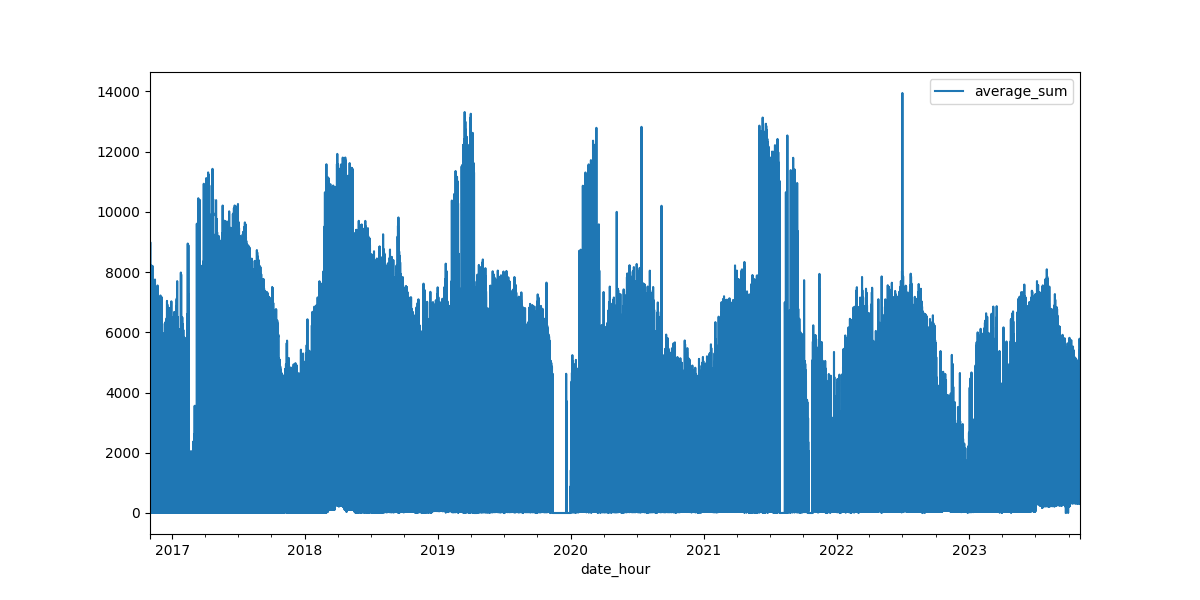

In [29]:
df_cmb01_hourly_complete = sdf_cmb01_hourly_complete.toPandas()
df_cmb01_hourly_complete.plot(x='date_hour', y='average_sum', figsize=(12, 6))
plt.show()
%matplot plt

<center>
    <h5>Figure 2. Total Combiner Box 1 DC Output</h5>
</center>

The total current (A) of combiner box 1 is plotted in <b>Figure 2</b> as part of data exploration.

The file is saved as a parquet file before clearing the memory so it can be used for the next operation.

In [14]:
sdf_cmb01_hourly_complete.write.parquet(
    "s3://bdcc2024-rlaylo/preprocessed_data/df_cmb01_hourly_complete.parquet")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<div>
    <h2 style="color:#0C5B80">7.4 Model Training</h2>
</div

The Combiner Box DC and Total Power datasets currently only contain the actual measurements captured per hour. Features must be included, which will be used by the models for forecasting predicted metrics. The use case of the study involves short-term forecasting, which gives a sufficient timeframe both for the solar power plant operators, as well as grid managers. The model will need to predict at least one week ahead using the previous week's data.

In [19]:
schema = StructType([
    StructField("date_hour", TimestampType(), True),
    StructField("average_sum", DoubleType(), True)
])

sdf_cmb01_hourly_complete = spark.read.parquet(
    "s3://bdcc2024-rlaylo/preprocessed_data/df_cmb01_hourly_complete.parquet",
    schema=schema).withColumnRenamed("average_sum", "CMB_01_Current")

sdf_cmb01_hourly_complete.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date_hour: timestamp (nullable = true)
 |-- CMB_01_Current: double (nullable = true)

Three main types of features will be utilized for predictions, benchmarking a SparkML time-series study conducted by Bharadwaj (2019).
1. Lag features: Each hour that serves as the target value will have 24 corresponding lag features that are 168 to 194 hours earlier. This signifies the measurements captured exactly 7 days prior to the target value hour. In this sense, the target value per hour is being predicted using the entire 24 hours or one day, seven days or one week ago.
2. Trend features: A total of 23 trend features are derived by checking the trend between each lag feature. Each trend will be signified as either -1 or +1 depending on whether the trend is decreasing or increasing, respectively.
3. Rolling mean of lag features: The rolling mean of the 24 lag columns is used as the final feature.

The two forecasting models will be trained using Random Forest regressors available in the SparkML package. An ensemble model was chosen due to three reasons. Firstly, there is no need for normalize the data in order for the model to perform well, reducing the preprocessing steps needed. Second, the model runs relatively fast in comparison to other available models in SparkML. Lastly, previous related works have used ensemble models with promising results.

To find the best model, grid search will be conducted with the following parameters:
- Number of Trees: 50, 100, 150
- Max Depth: 5, 10, 15

The best model is selected based on the best resulting validation metric. In the case of the study, the mean average error (MAE) and root mean squared error (RMSE) is used to determine the best model parameters, as the study deals with a regression problem.

In [33]:
# Get the minimum and maximum timestamp
min_timestamp = sdf_cmb01_hourly_complete.select(
    min("date_hour")).collect()[0][0]
max_timestamp = sdf_cmb01_hourly_complete.select(
    max("date_hour")).collect()[0][0]

# Calculate the date one year before the max_timestamp
end_val = max_timestamp.replace(year=max_timestamp.date().year - 1)
end_train = max_timestamp.replace(year=max_timestamp.date().year - 2)

print(f'Minimum timestamp: {min_timestamp}')
print(f'End of training: {end_train}')
print(f'End of validation: {end_val}')
print(f'Maximum timestamp: {max_timestamp}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Minimum timestamp: 2016-11-01 05:00:00
End of training: 2021-10-31 23:00:00
End of validation: 2022-10-31 23:00:00
Maximum timestamp: 2023-10-31 23:00:00

An additional column for index number is added to the dataframe to retain the order of the data. This is important as the order of the timing for the data segregation between the training, validation and holdout sets must be strictly adhered to.

The last and most recent year is used as the holdout set. The second most recent year is set aside as the validation set. The remaining 4.9 years worth of data will be used for the training of the models.

In [78]:
trainRatio = (end_train - min_timestamp) / (max_timestamp - min_timestamp)
valRatio = (end_val - end_train) / (max_timestamp - min_timestamp)
testRatio = (max_timestamp - end_val) / (max_timestamp - min_timestamp)

trainRatio, valRatio, testRatio

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7143695588379145, 0.14281522058104273, 0.14281522058104273)

In [79]:
# Forecasting 1 week (168 hours) in advance
forecast_hours = 168
n_lags = 24
time_series_column = "CMB_01_Current"
regressor = "RandomForestRegression"

(tvs_model_rf, best_params_rf, predictions_val_rf, predictions_test_rf,
 rmse_val_rf, rmse_test_rf, mae_val_rf, mae_test_rf) = ForecastWithGridSearch(
     sdf_cmb01_hourly_complete, forecast_hours, n_lags, time_series_column,
     regressor, trainRatio, valRatio, testRatio, spark)

# Print results
print(f"Validation RMSE: {rmse_val_rf}")
print(f"Test RMSE: {rmse_test_rf}")
print(f"Validation MAE: {mae_val_rf}")
print(f"Test MAE: {mae_test_rf}\n\n")
print(f"Best Parameters: {best_params_rf}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Validation RMSE: 938.6852633841062
Test RMSE: 1176.4279701556181
Validation MAE: 516.2767315458073
Test MAE: 680.4656856212217


Best Parameters: {'bootstrap': True, 'cacheNodeIds': False, 'checkpointInterval': 10, 'featureSubsetStrategy': 'auto', 'featuresCol': 'features', 'impurity': 'variance', 'labelCol': 'label', 'leafCol': '', 'maxBins': 32, 'maxDepth': 15, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'minWeightFractionPerNode': 0.0, 'numTrees': 150, 'predictionCol': 'prediction', 'seed': 2502083311556356884, 'subsamplingRate': 1.0}

In [21]:
sdf_predictions_test_rf = predictions_test_rf.select('date_hour',
                                                     'CMB_01_Current',
                                                     'prediction')
sdf_predictions_test_rf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------------+------------------+
|          date_hour|    CMB_01_Current|        prediction|
+-------------------+------------------+------------------+
|2022-11-02 04:00:00| 83.35145950191409| 83.47947004416913|
|2022-11-02 05:00:00| 87.95937878989756| 82.98138782291858|
|2022-11-02 06:00:00| 84.97760093417327| 80.54143724692325|
|2022-11-02 07:00:00| 89.15954626133336| 83.25731428240556|
|2022-11-02 08:00:00| 86.88823214042597| 83.30503119974259|
|2022-11-02 09:00:00|  84.6899497252767| 83.81859359835481|
|2022-11-02 10:00:00| 86.61891621427121| 86.08025078995253|
|2022-11-02 11:00:00| 86.96537881405297|  92.8274751393381|
|2022-11-02 12:00:00| 87.84285791336083| 91.00489313144178|
|2022-11-02 13:00:00| 91.10948870995709| 90.73884018577772|
|2022-11-02 14:00:00|184.09416919656127| 291.7911726764209|
|2022-11-02 15:00:00| 2280.298076554384| 2666.432189796709|
|2022-11-02 16:00:00|3919.9287784974804| 3567.880023167997|
|2022-11-02 17:00:00| 3529.498035963588|

In [22]:
df_predictions_test_rf = sdf_predictions_test_rf.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

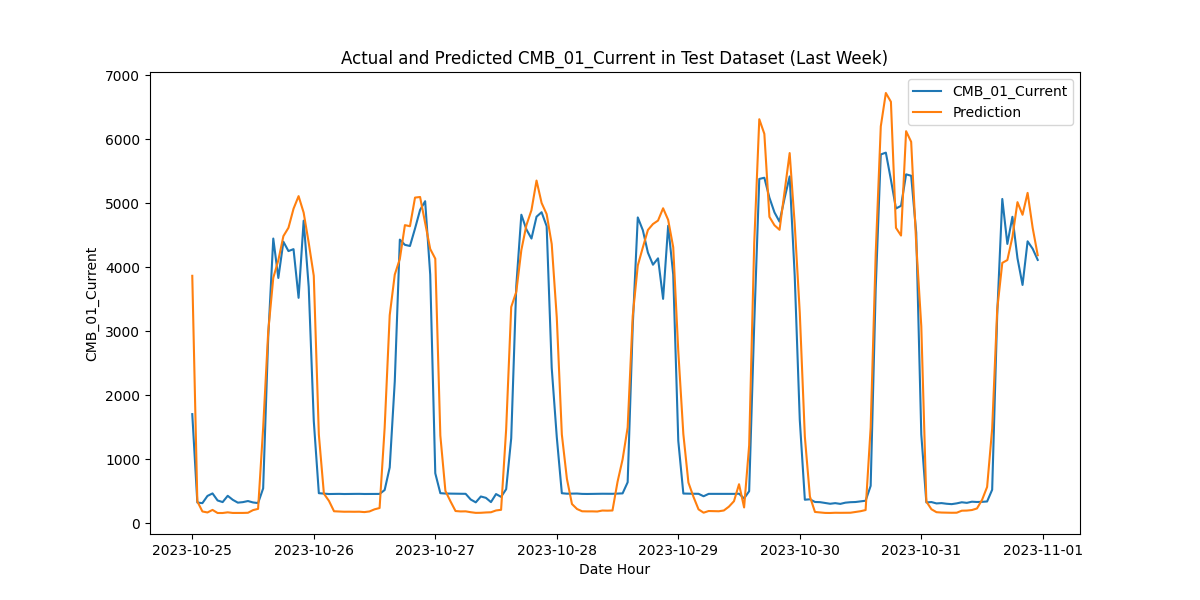

In [37]:
# Plot the data
plt.figure(figsize=(12, 6))

plt.plot(df_predictions_test_rf['date_hour'][-168:],
         df_predictions_test_rf['CMB_01_Current'][-168:],
         label='CMB_01_Current')
plt.plot(df_predictions_test_rf['date_hour'][-168:],
         df_predictions_test_rf['prediction'][-168:],
         label='Prediction')

# Add labels and title
plt.xlabel('Date Hour')
plt.ylabel('CMB_01_Current')
plt.title('Actual and Predicted CMB_01_Current in Test Dataset (Last Week)')
plt.legend()

# Show the plot
plt.show()
%matplot plt

<center>
    <h5>Figure 3. Actual and Predicted CMB 1 DC Output for Test Data (Last Week)</h5>
</center>

Displayed in <b>Figure 3</b> is the predicted versus actual DC values for the CMB 1 for the final week.

<a name='pow'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 8. Power Forecasting</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div>
    <h2 style="color:#0C5B80">8.1 Data Preparation</h2>
</div

The dataset is accessed from the AWS Open Data Registry.

In [40]:
meta_fpath = 's3://oedi-data-lake/pvdaq/2023-solar-data-prize/7333_OEDI/data/7333_rev_tag_list*.csv'
sdf_rev = spark.read.csv(meta_fpath, header=True, inferSchema=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
sdf_rev = sdf_rev.withColumnRenamed("_c0", "timestamp")
sdf_rev.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp: timestamp (nullable = true)
 |-- SOS-SUB-PRI-REV-FREQ-HZ: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZA-A: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZAB-KV: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZA-KV: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZA-MW: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZA-PF: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZB-A: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZBC-KV: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZB-KV: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZB-MW: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZB-PF: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZC-A: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZCA-KV: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZC-KV: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZC-MW: double (nullable = true)
 |-- SOS-SUB-PRI-REV-PHZC-PF: double (nullable = true)
 |-- SOS-SUB-PRI-REV-TOT-MW: double (nullable = true)
 |-- SOS-SUB-PRI-

<div>
    <h2 style="color:#0C5B80">8.2 Data Cleaning</h2>
</div

The dataset datapoints are already at hourly intervals, which is why the null values cannot be resolved by backfilling. In solar power plants, sensor values typically change within minutes.

In [14]:
sdf_rev_MW = sdf_rev.select('timestamp',
                            'SOS-SUB-PRI-REV-TOT-MW').orderBy('timestamp')

sdf_rev_MW_ffilled = forward_fill(sdf_rev_MW, 'timestamp')
sdf_rev_MW_ffilled = sdf_rev_MW_ffilled.fillna(0)
sdf_rev_MW_ffilled_hourly = (sdf_rev_MW_ffilled
                             .withColumn("date_hour", F
                                         .date_format("timestamp", "yyyy-MM-dd HH:00"))
                             .groupBy("date_hour")
                             .agg(F.avg("SOS-SUB-PRI-REV-TOT-MW").alias("MW_hourly"))
                             .orderBy("date_hour")
                            )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Save to a Parquet file and then free up memory to use in the next operation.

In [17]:
sdf_rev_MW_ffilled_hourly.write.parquet(
    "s3a://bdcc2024-rlaylo/preprocessed_data/sdf_rev_MW_ffilled_hourly_.parquet"
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
schema = StructType([
    StructField("date_hour", TimestampType(), True),
    StructField("MW_hourly", DoubleType(), True)
])

sdf_rev_MW_ffilled_hourly = spark.read.parquet(
    "s3a://bdcc2024-rlaylo/preprocessed_data/sdf_rev_MW_ffilled_hourly_.parquet",
    schema=schema)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.orderBy('date_hour')
sdf_rev_MW_ffilled_hourly.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+---------+
|       date_hour|MW_hourly|
+----------------+---------+
|2016-11-01 05:00|      0.0|
|2016-11-01 06:00|      0.0|
|2016-11-01 07:00|      0.0|
|2016-11-01 08:00|      0.0|
|2016-11-01 09:00|      0.0|
|2016-11-01 10:00|      0.0|
|2016-11-01 11:00|      0.0|
|2016-11-01 12:00|      0.0|
|2016-11-01 13:00|      0.0|
|2016-11-01 14:00|      0.0|
|2016-11-01 15:00|      0.0|
|2016-11-01 16:00|      0.0|
|2016-11-01 17:00|      0.0|
|2016-11-01 18:00|      0.0|
|2016-11-01 19:00|      0.0|
|2016-11-01 20:00|      0.0|
|2016-11-01 21:00|      0.0|
|2016-11-01 22:00|      0.0|
|2016-11-01 23:00|      0.0|
|2016-11-02 00:00|      0.0|
+----------------+---------+
only showing top 20 rows

In [10]:
df_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

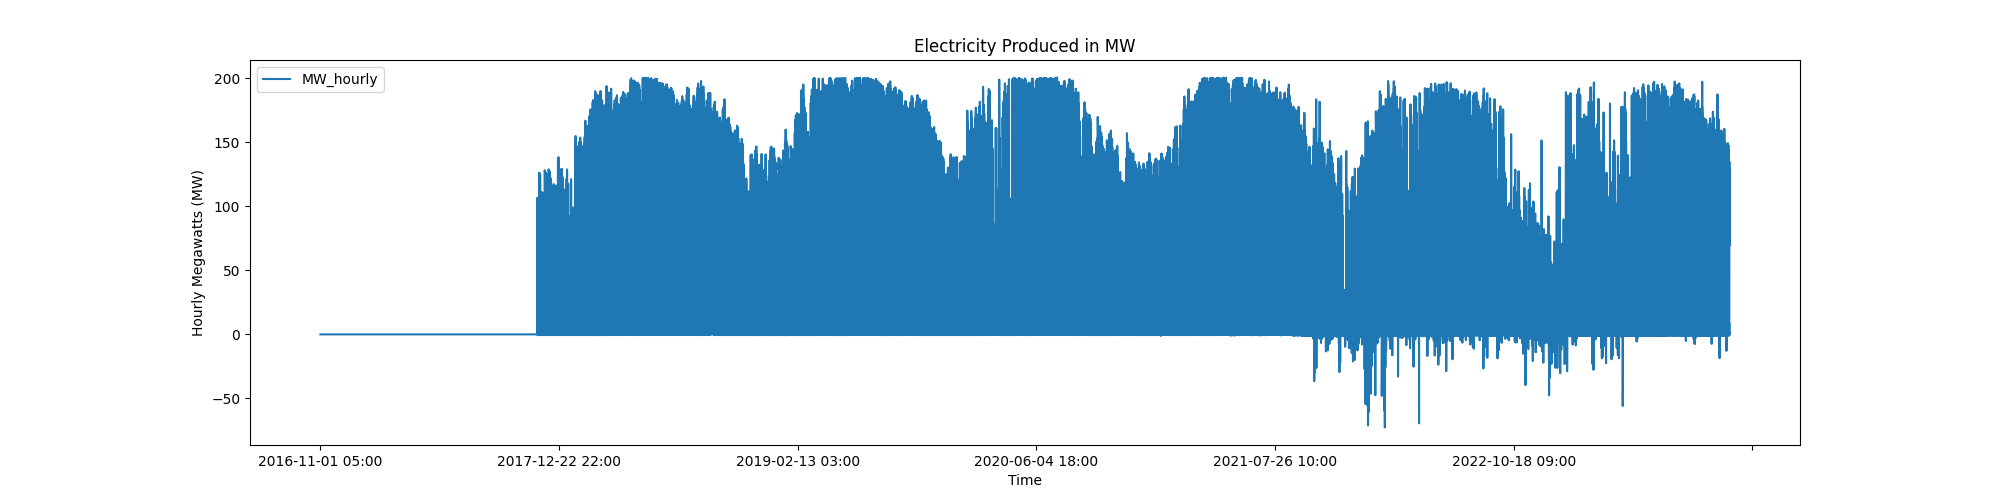

In [11]:
df_rev_MW_ffilled_hourly.plot(x='date_hour', y='MW_hourly', figsize=(20, 5))
# Add labels and title
plt.xlabel('Time')
plt.ylabel('Hourly Megawatts (MW)')
plt.title('Electricity Produced in MW')
plt.legend()
%matplot plt

<center>
    <h5>Figure 4. Electricity Produced (MW)</h5>
</center>

It can be seen in <b>Figure 4</b> that dates before 2017-11-14 17:00:00 have values of 0. Therefore, those will be removed.

In [44]:
# Convert date_hour column to timestamp type if it's not already
sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.withColumn(
    "date_hour", F.to_timestamp("date_hour"))

# Filter the DataFrame to keep rows where date_hour is greater than or equal to valid starting date
sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.filter(
    F.col("date_hour") >= F.lit("2017-11-14 17:00:00"))
sdf_rev_MW_ffilled_hourly.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+
|          date_hour|           MW_hourly|
+-------------------+--------------------+
|2017-11-14 17:00:00|     33.696218487395|
|2017-11-14 18:00:00|  106.60901287553651|
|2017-11-14 19:00:00|  105.02133891213357|
|2017-11-14 20:00:00|  102.57510373443988|
|2017-11-14 21:00:00|   93.82768595041317|
|2017-11-14 22:00:00|   57.17136929460586|
|2017-11-14 23:00:00|   41.67551867219922|
|2017-11-15 00:00:00|  11.596624472573897|
|2017-11-15 01:00:00|-0.25203619909502245|
|2017-11-15 02:00:00|                -0.5|
|2017-11-15 03:00:00|                -0.5|
|2017-11-15 04:00:00|                -0.5|
|2017-11-15 05:00:00|                -0.5|
|2017-11-15 06:00:00|                -0.5|
|2017-11-15 07:00:00|                -0.5|
|2017-11-15 08:00:00|                -0.5|
|2017-11-15 09:00:00|                -0.5|
|2017-11-15 10:00:00|                -0.5|
|2017-11-15 11:00:00|                -0.5|
|2017-11-15 12:00:00|                -0.5|
+----------

In [24]:
sdf_rev_MW_ffilled_hourly.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date_hour: timestamp (nullable = true)
 |-- MW_hourly: double (nullable = true)

<div>
    <h2 style="color:#0C5B80">8.3 Model Training</h2>
</div

The minimum and maximum values are taken to partition the dataset into train, validation, and test sets. The test set will be the last year of data. The validation set will be the data from 1 to 2 years before the latest date. The training set will be the data from any dates earlier than that.

In [26]:
# Get the minimum and maximum timestamp
min_timestamp = sdf_rev_MW_ffilled_hourly.select(
    min("date_hour")).collect()[0][0]
max_timestamp = sdf_rev_MW_ffilled_hourly.select(
    max("date_hour")).collect()[0][0]

# Calculate the date one year before the max_timestamp
end_val = max_timestamp.replace(year=max_timestamp.date().year - 1)
end_train = max_timestamp.replace(year=max_timestamp.date().year - 2)

print(f'Minimum timestamp: {min_timestamp}')
print(f'End of training: {end_train}')
print(f'End of validation: {end_val}')
print(f'Maximum timestamp: {max_timestamp}')

trainRatio = (end_train - min_timestamp) / (max_timestamp - min_timestamp)
valRatio = (end_val - end_train) / (max_timestamp - min_timestamp)
testRatio = (max_timestamp - end_val) / (max_timestamp - min_timestamp)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Minimum timestamp: 2017-11-11 00:00:00
End of training: 2021-10-31 23:00:00
End of validation: 2022-10-31 23:00:00
Maximum timestamp: 2023-10-31 23:00:00

In [27]:
trainRatio, valRatio, testRatio

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.6652847563188965, 0.16735762184055175, 0.16735762184055175)

In [30]:
# Forecasting 1 week (168 hours) in advance
forecast_hours = 168
n_lags = 24
time_series_column = "MW_hourly"
regressor = "RandomForestRegression"

(MW_tvs_model_rf, MW_best_params_rf, MW_predictions_val_rf,
 MW_predictions_test_rf, MW_rmse_val_rf, MW_rmse_test_rf, MW_mae_val_rf,
 MW_mae_test_rf) = ForecastWithGridSearch(sdf_rev_MW_ffilled_hourly,
                                          forecast_hours, n_lags,
                                          time_series_column, regressor,
                                          trainRatio, valRatio, testRatio,
                                          spark)

# Print results
print(f"Validation RMSE: {MW_rmse_val_rf}")
print(f"Test RMSE: {MW_rmse_test_rf}")
print(f"Validation MAE: {MW_mae_val_rf}")
print(f"Test MAE: {MW_mae_test_rf}\n\n")
print(f"Best Parameters: {MW_best_params_rf}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Validation RMSE: 21.61082059857411
Test RMSE: 38.54190174207685
Validation MAE: 15.803868145629249
Test MAE: 28.242363254770492


Best Parameters: {'bootstrap': True, 'cacheNodeIds': False, 'checkpointInterval': 10, 'featureSubsetStrategy': 'auto', 'featuresCol': 'features', 'impurity': 'variance', 'labelCol': 'label', 'leafCol': '', 'maxBins': 32, 'maxDepth': 15, 'maxMemoryInMB': 256, 'minInfoGain': 0.0, 'minInstancesPerNode': 1, 'minWeightFractionPerNode': 0.0, 'numTrees': 100, 'predictionCol': 'prediction', 'seed': 2502083311556356884, 'subsamplingRate': 1.0}

In [34]:
sdf_MW_predictions_test_rf = MW_predictions_test_rf.select(
    'date_hour', 'MW_hourly', 'prediction')
sdf_MW_predictions_test_rf.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+------------------+
|          date_hour|           MW_hourly|        prediction|
+-------------------+--------------------+------------------+
|2022-11-16 10:00:00| -0.7925000000000006|19.443657570897425|
|2022-11-16 11:00:00|   -0.77638888888889|26.443311615371673|
|2022-11-16 12:00:00|  -0.811111111111111|24.292799694539926|
|2022-11-16 13:00:00|  3.3793296089385474| 33.86794475647112|
|2022-11-16 14:00:00|   52.63904494382031| 60.13794149197204|
|2022-11-16 15:00:00|   99.05250000000004| 72.95828557621198|
|2022-11-16 16:00:00|   95.40388888888891| 78.27562210953518|
|2022-11-16 17:00:00|   90.80557103064065| 85.35971916038845|
|2022-11-16 18:00:00|   94.95972222222238| 87.93074776122897|
|2022-11-16 19:00:00|  34.633333333333326|  54.6164085713355|
|2022-11-16 20:00:00|    54.6363888888889| 58.73865851052303|
|2022-11-16 21:00:00|   91.09805555555552| 83.72371197221595|
|2022-11-16 22:00:00|   37.38972222222223| 54.02925323444866|
|2022-11

In [35]:
df_MW_predictions_test_rf = sdf_MW_predictions_test_rf.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

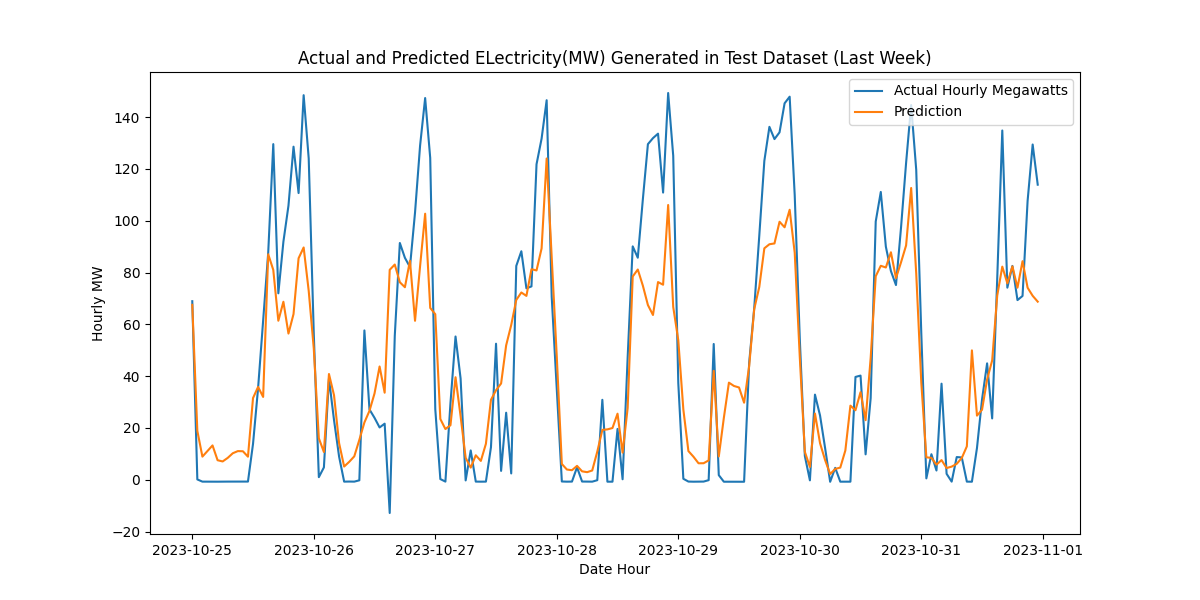

In [42]:
# Plot the data
plt.figure(figsize=(12, 6))

plt.plot(df_MW_predictions_test_rf['date_hour'][-168:],
         df_MW_predictions_test_rf['MW_hourly'][-168:],
         label='Actual Hourly Megawatts')
plt.plot(df_MW_predictions_test_rf['date_hour'][-168:],
         df_MW_predictions_test_rf['prediction'][-168:],
         label='Prediction')

# Add labels and title
plt.xlabel('Date Hour')
plt.ylabel('Hourly MW')
plt.title(
    'Actual and Predicted ELectricity(MW) Generated in Test Dataset (Last Week)'
)
plt.legend()

# Show the plot
plt.show()
%matplot plt

<center>
    <h5>Figure 5. Actual and Predicted Electricity (MW) Generated in Test Dataset (Last Week)</h5>
</center>

Seen in <b>Figure 5</b> are the actual and preducted power generated in the last week of the test dataset.

<a name='model_evaluations'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 9. Model Evaluation</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div>
    <h2 style="color:#0C5B80">9.1 DC Forecasting Evaluation</h2>
</div

The models must be compared to a baseline test performance. The baseline model is based on a naive model, wherein the predicted value is based on the actual value measured that hour but directly 7 days ago.

The resulting MAE and RMSE for the baseline model is computed below.

In [90]:
forecast_hours = 168
timeSeriesColumn = "CMB_01_Current"
cutoff_date = "2022-10-31 00:00:00"

# Evaluate baseline
(RMSE_baseline_train, RMSE_baseline_test,
 MAE_baseline_train, MAE_baseline_test, df_baseline_test) = evaluate_baseline(
    sdf_cmb01_hourly_complete, forecast_hours, timeSeriesColumn, cutoff_date)

# Show results
print(f"RMSE (baseline train): {RMSE_baseline_train}")
print(f"RMSE (baseline test): {RMSE_baseline_test}")
print(f"MAE (baseline train): {MAE_baseline_train}")
print(f"MAE (baseline test): {MAE_baseline_test}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE (baseline train): 1949.1705516151296
RMSE (baseline test): 1227.2626831181553
MAE (baseline train): 910.7511012212959
MAE (baseline test): 604.6003963975064

In [91]:
# Create a list of rows containing the results
results = [
    Row(Metric="Test RMSE", Score=rmse_test_rf, Baseline=RMSE_baseline_test),
    Row(Metric="Test MAE", Score=mae_test_rf, Baseline=MAE_baseline_test)
]

results_df = spark.createDataFrame(results)
results_df = results_df.withColumn("Score", round(results_df["Score"], 2))
results_df = results_df.withColumn("Baseline", round(results_df["Baseline"], 2))

# Rename the Score column to RandomForest
results_df = results_df.withColumnRenamed("Score", "RandomForest")

# Show the results DataFrame
results_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------+--------+
|   Metric|RandomForest|Baseline|
+---------+------------+--------+
|Test RMSE|     1176.43| 1227.26|
| Test MAE|      680.47|   604.6|
+---------+------------+--------+

<div>
    <h2 style="color:#0C5B80">9.2 Power Forecasting Evaluation</h2>
</div

In [32]:
# Parameters
forecast_hours = 168
timeSeriesColumn = "MW_hourly"
cutoff_date = "2022-10-31 00:00:00"

# Evaluate baseline
(MW_RMSE_baseline_train, MW_RMSE_baseline_test, MW_MAE_baseline_train,
 MW_MAE_baseline_test,
 MW_df_baseline_test) = evaluate_baseline(sdf_rev_MW_ffilled_hourly,
                                          forecast_hours, timeSeriesColumn,
                                          cutoff_date)
# Show results
print(f"RMSE (baseline train): {MW_RMSE_baseline_train}")
print(f"RMSE (baseline test): {MW_RMSE_baseline_test}")
print(f"MAE (baseline train): {MW_MAE_baseline_train}")
print(f"MAE (baseline test): {MW_MAE_baseline_test}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE (baseline train): 48.62700282150583
RMSE (baseline test): 41.43425388007964
MAE (baseline train): 24.369033045465024
MAE (baseline test): 25.366309423375593

In [59]:
# Create a list of rows containing the results
results = [
    Row(Metric="Test RMSE",
        Score=MW_rmse_test_rf,
        Baseline=MW_RMSE_baseline_test),
    Row(Metric="Test MAE", Score=MW_mae_test_rf, Baseline=MW_MAE_baseline_test)
]

results_df = spark.createDataFrame(results)
results_df = results_df.withColumn("Score", round(results_df["Score"], 2))
results_df = results_df.withColumn("Baseline", round(results_df["Baseline"], 2))

# Rename the Score column to RandomForest
results_df = results_df.withColumnRenamed("Score", "RandomForest")

# Show the results DataFrame
results_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------+--------+
|   Metric|RandomForest|Baseline|
+---------+------------+--------+
|Test RMSE|       38.54|   41.43|
| Test MAE|       28.24|   25.37|
+---------+------------+--------+

<a name='mutual_informations'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 10. Mutual Information</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div>
    <h2 style="color:#0C5B80">10.1 Data Preparation</h2>
</div

The weather and inverter dataset contains 14 tag groups, each with different columns. The process will involve looping through each tag group to combine them.

In [11]:
sdf_ws_combined = None

# Loop through tag groups 1 to 14
for i in range(1, 15):
    tag_group_pattern = f'tag_group_{str(i).zfill(2)}'
    tag_group_name = f'group_{i}'

    sdf_agg_tag_group = process_tag_group(tag_group_pattern, tag_group_name)

    if sdf_ws_combined is None:
        sdf_ws_combined = sdf_agg_tag_group
    else:
        sdf_ws_combined = sdf_ws_combined.join(sdf_agg_tag_group,
                                               on="_c0",
                                               how="outer")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Irradiance, DC, and AC electrical sensors were removed because they are multicollinear with the target variable, the megawatts of electricity produced, which can cause data leakage.

In [16]:
columns_to_drop = [
    col for col in sdf_ws_combined.columns
    if 'AC' in col or 'DC' in col or 'Irradiance' in col
]
sdf_ws_combined_filtered = sdf_ws_combined.drop(*columns_to_drop)
sdf_ws_combined_filtered = sdf_ws_combined_filtered.withColumnRenamed(
    '_c0', 'timestamp')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<div>
    <h2 style="color:#0C5B80">10.2 Data Aggregation</h2>
</div

The inverter features, temp_enclosure, temp_ambient, power factor, temp_module, wind_durection, and windspeed are aggregated to one dataframe.

In [13]:
# Define the column groups
temp_enclosure_cols = [
    col_name for col_name in sdf_ws_combined_filtered.columns
    if 'Temperature enclosure' in col_name
]
temp_ambient_cols = [
    col_name for col_name in sdf_ws_combined_filtered.columns
    if 'Temperature ambient' in col_name
]
pf_columns = [
    col_name for col_name in sdf_ws_combined_filtered.columns
    if 'INV1-PF' in col_name
]
temp_module_cols = [
    col_name for col_name in sdf_ws_combined_filtered.columns
    if 'Temperature module' in col_name
]
wind_dir_cols = [
    col_name for col_name in sdf_ws_combined_filtered.columns
    if 'Wind direction' in col_name
]
wind_speed_cols = [
    col_name for col_name in sdf_ws_combined_filtered.columns
    if 'Wind speed' in col_name
]

# Calculate the averages and add them as new columns
sdf_ws_combined_filtered = (average_columns(sdf_ws_combined_filtered,
                                            temp_enclosure_cols,
                                            'avg_temperature_enclosure'))
sdf_ws_combined_filtered = (average_columns(sdf_ws_combined_filtered,
                                            temp_ambient_cols,
                                            'avg_temperature_ambient'))
sdf_ws_combined_filtered = (average_columns(sdf_ws_combined_filtered,
                                            pf_columns, 'avg_pf'))
sdf_ws_combined_filtered = (average_columns(sdf_ws_combined_filtered,
                                            temp_module_cols,
                                            'avg_temperature_module'))
sdf_ws_combined_filtered = (average_columns(sdf_ws_combined_filtered,
                                            wind_dir_cols,
                                            'avg_wind_direction'))
sdf_ws_combined_filtered = (average_columns(sdf_ws_combined_filtered,
                                            wind_speed_cols, 'avg_wind_speed'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
columns_to_drop = (temp_enclosure_cols + temp_ambient_cols + pf_columns +
                   temp_module_cols + wind_dir_cols + wind_speed_cols)

sdf_ws_combined_filtered = sdf_ws_combined_filtered.drop(*columns_to_drop)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
sdf_ws_combined_filtered.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp: timestamp (nullable = true)
 |-- avg_temperature_enclosure: double (nullable = true)
 |-- avg_temperature_ambient: double (nullable = true)
 |-- avg_pf: double (nullable = true)
 |-- avg_temperature_module: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)

The file is saved to a Parquet format to clear up memory for the next operation.

In [18]:
output_path = 's3://bdcc2024-rlaylo/preprocessed_data/ws_avg_filtered.parquet'
sdf_ws_combined_filtered.write.format("parquet").mode("overwrite").save(
    output_path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
sdf_ws_combined_filtered.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp: timestamp (nullable = true)
 |-- avg_temperature_enclosure: double (nullable = true)
 |-- avg_temperature_ambient: double (nullable = true)
 |-- avg_pf: double (nullable = true)
 |-- avg_temperature_module: double (nullable = true)
 |-- avg_wind_direction: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)

In [24]:
sdf_ws_combined_filtered = sdf_ws_combined_filtered.orderBy('timestamp')
sdf_ws_combined_filtered.persist().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-------------------------+-----------------------+------+----------------------+------------------+------------------+
|          timestamp|avg_temperature_enclosure|avg_temperature_ambient|avg_pf|avg_temperature_module|avg_wind_direction|    avg_wind_speed|
+-------------------+-------------------------+-----------------------+------+----------------------+------------------+------------------+
|2016-11-01 05:00:00|                      0.0|     11.715738856124265|   0.0|    13.701554659406565| 232.5987810651328|1.0134293022491596|
|2016-11-01 06:00:00|                      0.0|     11.451507997222226|   0.0|            13.3355665|147.23720194290166|1.1631254271098745|
|2016-11-01 07:00:00|                      0.0|     11.900196220508658|   0.0|    13.854961558928572|177.62502309901464|0.7013225672246013|
|2016-11-01 08:00:00|                      0.0|     11.858295523909508|   0.0|    14.338580479166666| 217.7715364427513|0.6604836163070702|
|2016-11-01 09:00:00

The null values are filled with zeroes since they don't have values for more than an hour.

In [25]:
sdf_ws_combined_filtered = sdf_ws_combined_filtered.fillna(0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
schema = StructType([
    StructField("date_hour", TimestampType(), True),
    StructField("MW_hourly", DoubleType(), True)
])

sdf_rev_MW_ffilled_hourly = spark.read.parquet(
    "s3a://bdcc2024-rlaylo/preprocessed_data/sdf_rev_MW_ffilled_hourly_.parquet",
    schema=schema)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.withColumn(
    "date_hour", F.to_timestamp("date_hour"))
sdf_rev_MW_ffilled_hourly.printSchema()

sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.orderBy('date_hour')

# Filter the DataFrame to valid starting date
sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.filter(
    F.col("date_hour") >= F.lit("2017-11-14 17:00:00"))
sdf_rev_MW_ffilled_hourly.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+--------------------+
|          date_hour|           MW_hourly|
+-------------------+--------------------+
|2017-11-14 17:00:00|     33.696218487395|
|2017-11-14 18:00:00|  106.60901287553651|
|2017-11-14 19:00:00|  105.02133891213357|
|2017-11-14 20:00:00|  102.57510373443988|
|2017-11-14 21:00:00|   93.82768595041317|
|2017-11-14 22:00:00|   57.17136929460586|
|2017-11-14 23:00:00|   41.67551867219922|
|2017-11-15 00:00:00|  11.596624472573897|
|2017-11-15 01:00:00|-0.25203619909502245|
|2017-11-15 02:00:00|                -0.5|
|2017-11-15 03:00:00|                -0.5|
|2017-11-15 04:00:00|                -0.5|
|2017-11-15 05:00:00|                -0.5|
|2017-11-15 06:00:00|                -0.5|
|2017-11-15 07:00:00|                -0.5|
|2017-11-15 08:00:00|                -0.5|
|2017-11-15 09:00:00|                -0.5|
|2017-11-15 10:00:00|                -0.5|
|2017-11-15 11:00:00|                -0.5|
|2017-11-15 12:00:00|                -0.5|
+----------

The date_hour column is renamed to timestamp to match the other DataFrame.

In [45]:
sdf_rev_MW_ffilled_hourly = sdf_rev_MW_ffilled_hourly.withColumnRenamed(
    "date_hour", "timestamp")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The join operation is performed on the timestamp column to complete the timestamp, then the null values are filled with zero.

In [51]:
sdf_rev_ws = sdf_rev_MW_ffilled_hourly.join(sdf_ws_combined_filtered,
                                            on="timestamp",
                                            how="outer")
sdf_rev_ws = sdf_rev_ws.fillna(0)
sdf_rev_ws = sdf_rev_ws.drop('timestamp')
sdf_rev_ws.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------------------------+-----------------------+------+----------------------+------------------+-------------------+
|MW_hourly|avg_temperature_enclosure|avg_temperature_ambient|avg_pf|avg_temperature_module|avg_wind_direction|     avg_wind_speed|
+---------+-------------------------+-----------------------+------+----------------------+------------------+-------------------+
|      0.0|                      0.0|     11.715738856124265|   0.0|    13.701554659406565| 232.5987810651328| 1.0134293022491596|
|      0.0|                      0.0|     10.710049419052343|   0.0|    12.511736355555556| 252.8451643875882| 1.5974395773293237|
|      0.0|                      0.0|     16.428206891355643|   0.0|    20.606007610864154|251.38498933587923| 1.7584498546832317|
|      0.0|                      0.0|     18.215388409254455|   0.0|     22.79886121267476|200.44114346470099| 0.6220475902190362|
|      0.0|                      0.0|     14.765499491905668|   0.0|     19.1191637

In [57]:
feature_columns = [
    'avg_temperature_enclosure', 'avg_temperature_ambient', 'avg_pf',
    'avg_temperature_module', 'avg_wind_direction', 'avg_wind_speed'
]

# Assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns,
                                   outputCol="features")
df_vector = vector_assembler.transform(sdf_rev_ws)

pandas_df = df_vector.select('features', 'MW_hourly').toPandas()
pandas_df_features = pd.DataFrame(pandas_df['features'].tolist(),
                                  columns=feature_columns)
y = pandas_df['MW_hourly']

# Compute mutual information scores
mutual_info = mutual_info_regression(pandas_df_features, y)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

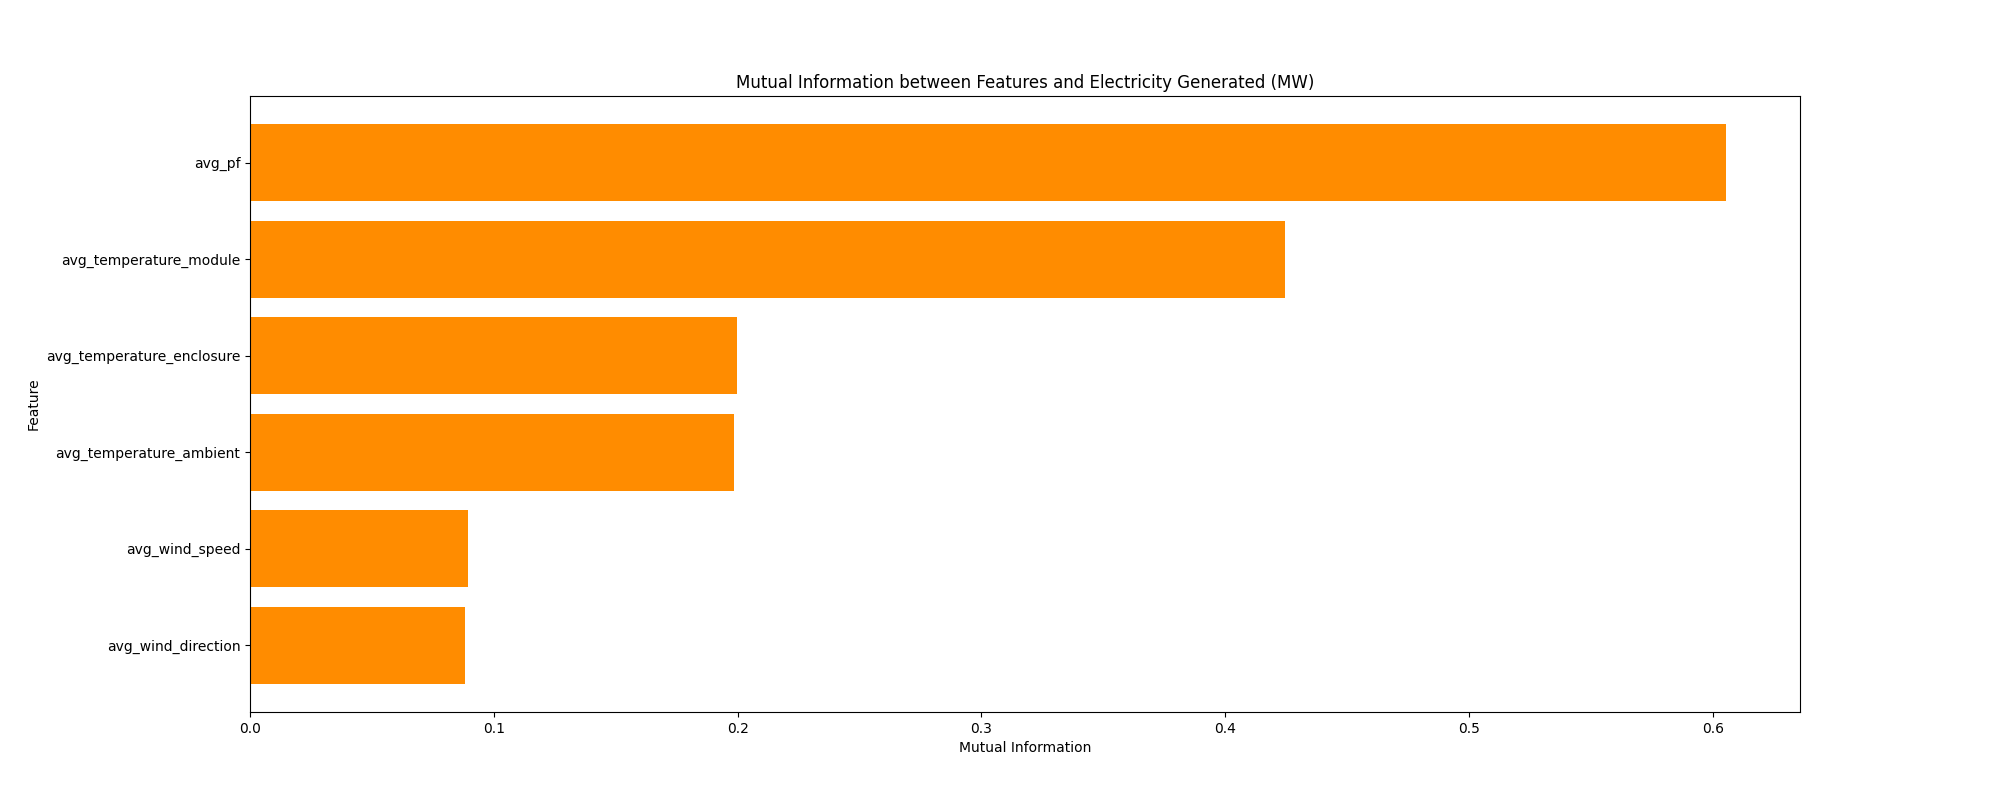

In [62]:
mi_df = pd.DataFrame({
    'Feature': feature_columns,
    'Mutual Information': mutual_info
})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Plot the mutual information scores
plt.figure(figsize=(20, 8))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'], color='darkorange')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information between Features and Electricity Generated (MW)')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest MI at the top
plt.show()
%matplot plt

<center>
    <h5>Figure 6. Mutual Information between Features and Electricity Generated</h5>
</center>

Shown in <b>Figure 6</b> are the factors that share mutual information with the electricity generated by the plant.

<a name='results_and_discussions'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 11. Results and Discussion</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

- <b>Stability vs Accuracy</b>

    When evaluating week-ahead solar power forecasts, Root Mean Squared Error (RMSE) is often preferred over Mean Absolute Error (MAE) due to its sensitivity to large errors. This sensitivity is particularly important in solar power systems, where large forecast errors can disrupt the balance between power generation and grid demand, leading to operational inefficiencies and potential financial losses (Zameer et. al, 2023).

    Our time series forecasting model exhibits a key advantage in this regard. While the baseline model might achieve closer values on average (represented by a better MAE), our model demonstrates superior stability, especially when encountering anomalous data points caused by unexpected weather events or equipment malfunctions. These outliers can significantly skew the RMSE metric. The baseline model, by simply assuming constant historical production, gets heavily penalized by RMSE when encountering such anomalies.

- <b>Feature Importance</b>

    Our analysis using mutual information provided valuable insights into the features most critical for predicting solar power generation. The results were quite interesting!  Power factor emerged as the top feature, followed closely by a trio of temperature measurements: module temperature, ambient temperature, and enclosure temperature. This suggests a two-pronged impact on power generation:

    - <b>Inverter and Transformer Inefficiencies:</b> Results of mutual information analysis revealed that power factor is a key indicator of potential inefficiencies within the solar power generation system. A lower power factor suggests energy losses, likely occurring between the inverters and transformers. This valuable information serves as an early warning sign for plant operators to conduct inspection or maintenance.  
    - <b>Temperature Effects:</b> Our findings establish the crucial role of temperature in determining solar power generation. As highlighted in research by Ecoflow (2023), solar panel efficiency typically declines by 0.3% to 0.5% for every degree Celsius above 25°C (77°F). This knowledge is particularly valuable for solar plant designers and managers, as it helps set realistic expectations for summer power generation. Without considering temperature effects, sunny summer weather can lead to overly optimistic power generation projections.  By factoring in the temperature-efficiency relationship, plant managers can make informed decisions and potentially adjust expectations or implement mitigation strategies during the hottest months.

<a name='conclusions'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 12. Conclusion</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

This project successfully demonstrated the feasibility of training high-capacity time series forecasting models on Big Data for solar power generation. Handling of 380 gigabytes of data was made possible by availing cloud computing services from AWS. This enabled us to setup our own compute cluster that will allow us to perform distributed computing on Big Data.

The resulting power generated model was able to achieve 38.54 RMSE in comparison to 41.43 RMSE by performing naive prediction, assuming forecast window's power generation will be the same as the previous window. The DC collected model also achieved promising results, with an RMSE of 1176.43, an improvement from the baseline model RMSE of 1227.26.

Our analysis also identified two key factors impacting solar power generation: power factor and various facets of operating temperature. This aligns with the definition of Power factor, which is the efficiency of converting the panels' DC output into grid-compatible AC power. For temperature features, well-documented research confirms that solar panel output declines as temperature rises beyond the optimal 25°C (Solar Directory, n.d.).

<a name='recommendationss'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 13. Recommendations</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

- <b>Exploring the Impact of Lookback and Forecast Horizon:</b>

    This project focused on generating one-week forecasts, which offers valuable insights for short-term power grid management. However, the model's potential extends beyond this timeframe. By exploring different lookback periods and forecast horizons, we can unlock further benefits such as monthly and yearly forecasts.  

- <b>Transformer Based Models:</b>

    Recent advancements in transformer-based architectures for time series forecasting hold significant promise, particularly for longer horizons like weekly and monthly predictions. Pre-trained models like TimeGPT have demonstrated superior performance compared to traditional methods for these extended forecast lengths.  

- <b>Multivariate Time Series Forecasting:</b>

    Powerful models can leverage multiple related time series data points (e.g., temperature, cloud cover) as inputs to predict a target variable (e.g., solar power generation). When these additional features significantly influence the target variable, incorporating them can substantially enhance forecast accuracy. However, this approach introduces increased model complexity, requiring careful consideration during implementation.  

- <b>Counterfactuals and Interpretability:</b>

    Exploring interpretability aspects of the model can provide great business value in the form of counterfactuals. A good example would be to determine how changes in temperature would affect the power generation. Counterfactuals could provide the necessary justification for operational adjustments, since it can give an idea of how much increase in power generation can be achieved by implementing temperature control measures.

<a name='referencess'></a>

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> 14. References</h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

ABS-CBN News. (2024, January 1). World's largest solar project breaks ground in PH, says SPNEC. https://news.abs-cbn.com/business/01/01/24/worlds-largest-solar-project-breaks-ground-in-ph-says-spnec

Berry, J. (2019, June 14). Handling missing values in time series with SQL. Medium. https://medium.com/@jberry_33001/handling-missing-values-in-time-series-with-sql-a910b5f481fe

Bharadwaj, S. (2019, December 30). Time series forecasting using Spark ML (Part 2). Medium. https://medium.com/analytics-vidhya/time-series-forecasting-using-spark-ml-part-2-31506514c643

Deline, Chris, Perry, Kirsten, Deceglie, Michael, Muller, Matthew, Sekulic, William, & Jordan, Dirk. Photovoltaic Data Acquisition (PVDAQ) Public Datasets. United States. https://dx.doi.org/10.25984/1846021

Department of Energy. (n.d.). Open Energy Data Initiative (OEDI). Retrieved June 8, 2024, from https://registry.opendata.aws/oedi-data-lake/

Department of Energy. (n.d.). Philippine Energy Plan (PEP). Retrieved June 8, 2024, from https://doe.gov.ph/pep

Ecoflow. (2023). The Impact of Temperature on Solar Panel Efficiency: How Heat Affects Your Solar Energy System. EcoFlow AU Blog. https://blog.ecoflow.com/au/effects-of-temperature-on-solar-panel-efficiency/

Inquirer.net. (2024, May 23). Power outage hits parts of Metro Manila, nearby areas Thursday. https://newsinfo.inquirer.net/1944236/power-outage-hits-parts-of-metro-manila-nearby-areas-thursday

Meralco. (n.d.). Why are we experiencing rotating brownouts? https://company.meralco.com.ph/news-and-advisories/why-are-we-experiencing-rotating-brownouts

Power Philippines. (2024, June 5). PH considers securing P31 trillion renewable energy investments by 2040. https://powerphilippines.com/ph-considers-securing-p31-trillion-renewable-energy-investments-by-2040/

Solar Directory. (n.d.). The Impact of High Temperatures on Solar Power Systems. Retrieved from https://www.solardirectory.com.au/solar-blog/2531-how-does-heat-affect-solar-power-systems

Zameer, A., Jaffar, F., Shahid, F., Muneeb, M., Khan, R., & Nasir, R. (2023). Short-term solar energy forecasting: Integrated computational intelligence of LSTMs and GRU. PloS One, 18(10), e0285410. https://doi.org/10.1371/journal.pone.0285410

<div style='display: flex; justify-content: space-between; align-items: center; background-color: #1c88bb; color: white; padding: 10px; width: 100%; border-top: 3px solid #5ce1e6;'>
    <h1> Appendix </h1>
    <style='height: 50px; width: auto; margin-left: auto;'>
</div>

<div>
    <h2 style="color:#0C5B80">Screenshot of Instances</h2>
</div

<center>
    <img src='instances.png'>
</center>

<div>
    <h2 style="color:#0C5B80">Screenshot of EMR Cluster</h2>
</div

<center>
    <img src='emr.png'>
</center>

<div>
    <h2 style="color:#0C5B80">Screenshot of Total Size of Processed Data</h2>
</div

<center>
    <img src='filesize.png'>
</center>

## Total Size: 383.4 GiB